In [1]:
import awkward
import xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
#%pip install sklearn
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

import hist

In [2]:
xgboost.__version__

'2.0.3'

In [3]:
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
    
    

# Read files and normalise the weights

In [5]:
proc_dict = {
    "ggh_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_syst/merged/ggh_M125_2017/UNTAGGED_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 2,
    },
    "tth_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_syst/merged/tth_M125_2017/UNTAGGED_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 3,
    },
    "vbf_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_syst/merged/vbf_M125_2017/UNTAGGED_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 4,
    },
    "vh_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_syst/merged/vh_M125_2017/UNTAGGED_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 5,
    },
    "DiphotonBox_low_mass_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_bkg_syst/merged/DiphotonBox_low_mass_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -1,
    },
    "DiphotonBox_high_mass_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_bkg_SCeta_notrigger/merged/DiphotonBox_high_mass_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -1,
    },
    "GJets_HT-40To100_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJet_v11_incomplete/merged/GJets_HT-40To100_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-100To200_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJet_v11_incomplete/merged/GJets_HT-100To200_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-100To200_M125_2017_NEW": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_bkg_SCeta_notrigger/merged/GJets_HT-100To200_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -99,
    },
    "GJets_HT-100To200_M125_2017_OLD": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJetsOld_SCeta_notrigger/merged/GJets_HT-100To200_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -98,
    },
    "GJets_HT-200To400_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJet_v11_incomplete/merged/GJets_HT-200To400_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-400To600_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJet_v11_incomplete/merged/GJets_HT-400To600_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-600ToInf_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_GJet_v11_incomplete/merged/GJets_HT-600ToInf_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -2,
    },
    "DY_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_dy_notrigger/merged/DY_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -4,
    },
    "QCD_M125_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_QCD_v11_incomplete/merged/QCD_M125_2017/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -3,
    },
    "QCD_2017_mgg_low": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_QCD_v11_incomplete/merged/QCD_2017_mgg_low/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -3,
    },
    "QCD_2017_mgg_high_pt_30To40": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_QCD_v11_incomplete/merged/QCD_2017_mgg_high_pt_30To40/UNTAGGED_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": -3,
    },
    "Data_2017": {
        "file": "/pnfs/psi.ch/cms/trivcat/store/user/bevila_t/test2/phys/xpluscharm/HiggsDNA_output/output_dipho_data_v11_incomplete/merged/Data_2017/allData_UNTAGGED_merged.parquet",
        "type": "data",
        "label": -1.,
        "proc_id": 0,
    },
}

# concatenate the MC and Data events (separately) and add normalisation

In [6]:
with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master2/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [8]:
sig_events = []
bkg_events = []
data_events = []

columns = ['weight', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'LeadPhoton_pt', 'LeadPhoton_energy', 'LeadPhoton_energyErr', 'LeadPhoton_energyRaw', 'SubleadPhoton_energy', 'SubleadPhoton_energyErr', 'SubleadPhoton_energyRaw','SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ', 'dZ_1', 'dZ_2', 'dZ_3', "n_jets"]
               
for i, dataset in enumerate(proc_dict):
    if "Data" not in dataset:
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        print(f"{dataset}: xsec = {XSs[dataset]['xs']}, bf = {XSs[dataset]['bf']}, lumi = {XSs['lumi']['2017']}, norm = {norm}")
    else:
        print(f"{dataset}")
    if proc_dict[dataset]["type"] == "signal":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
    
    elif proc_dict[dataset]["type"] == "background":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm * 1.4
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm * 1.4 
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(bkg_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
    
    elif proc_dict[dataset]["type"] == "data":
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
data_events["label"] = ak.ones_like(data_events["weight"]) * -1.

ggh_M125_2017: xsec = 48.58, bf = 0.00227, lumi = 41.5, norm = 4576.4789
|----> sum normalised weights: 2010.3114746764538
tth_M125_2017: xsec = 0.5071, bf = 0.00227, lumi = 41.5, norm = 47.77135549999999
|----> sum normalised weights: 23.01389170920136
vbf_M125_2017: xsec = 3.782, bf = 0.00227, lumi = 41.5, norm = 356.28331
|----> sum normalised weights: 154.90799057214193
vh_M125_2017: xsec = 2.2555, bf = 0.00227, lumi = 41.5, norm = 212.47937749999997
|----> sum normalised weights: 82.15444848081044
DiphotonBox_low_mass_M125_2017: xsec = 299.3, bf = 1, lumi = 41.5, norm = 12420950.0
|----> sum normalised weights: 0.0
DiphotonBox_high_mass_M125_2017: xsec = 84.4, bf = 1, lumi = 41.5, norm = 3502600.0000000005
|----> sum normalised weights: 0.0
GJets_HT-40To100_M125_2017: xsec = 18650.0, bf = 1, lumi = 41.5, norm = 773975000.0
|----> sum normalised weights: 0.0
GJets_HT-100To200_M125_2017: xsec = 8639.0, bf = 1, lumi = 41.5, norm = 358518500.0
|----> sum normalised weights: 0.0
GJets_

In [9]:
MC_events = ak.concatenate([sig_events, bkg_events])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)
# MC_events.fields

In [14]:
config="diphoton_bdt_config.json"

with open(config, "r") as f_in:
    bdt_config = json.load(f_in)

## Anchor by diphoton_eta
eta_fields = [x for x in bdt_config["features"] if "eta" in x]
#for field in bdt_config["features"]:
#    if "dZ" in field:
#        events[field] = events[field] * np.sign(events[field])
#for field in eta_fields:
#    MC_events[field] = MC_events[field] * np.sign(MC_events.eta)

print("[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.")

print("[HiggsDNABonusTool] Out of %d total events, found %d signal and %d background events." % (len(MC_events), len(sig_events), len(bkg_events)))

# Split events for k-fold training
MC_events_kfold = []
MC_events_kfold.append(MC_events[((MC_events.event % 2) == 0)])
MC_events_kfold.append(MC_events[((MC_events.event % 2) == 1)])

# Add test/train/val split
for i, MC in enumerate(MC_events_kfold):
    split = np.random.randint(5, size = len(MC))
    MC_events_kfold[i]["train_split"] = awkward.from_numpy(split) # 0-3 = train, 4-5 = test, none = validation

    #events = awkward.nan_to_num(events, nan=-999., posinf=-999., neginf=-999.)
    print(len(MC_events_kfold[i][MC_events_kfold[i]["train_split"] < 4]), len(MC_events_kfold[i][MC_events_kfold[i]["train_split"] > 3]), len(MC_events_kfold[i][MC_events_kfold[i]["train_split"] >= 6]))

[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.
[HiggsDNABonusTool] Out of 7545766 total events, found 4409131 signal and 3173270 background events.
3018855 754097 0
3018985 753829 0


In [15]:
print(MC_events.event[0], MC_events.event[1], MC_events.event[2])
MC_events_kfold[i].event % 2

283863.0 283866.0 283875.0


<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='3772814 * ?float64'>

for field in eta_fields:
    data_events[field] = data_events[field] * np.sign(data_events.eta)

In [16]:
file = "abs_to_nominal.json"

import correctionlib
import correctionlib.schemav2 as cs

ceval = correctionlib.CorrectionSet.from_file(file)
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

var = "LeadPhoton_pt_mgg"
var2 = "SubleadPhoton_pt_mgg"

Correction abs_to_nominal has 2 inputs
   Input lead (real): lead pt/mgg
   Input sublead (real): sublead pt/mgg


In [17]:
bdt = []
d_train = []
d_test = []
events_train = []
events_test = []

for i, MC in enumerate(MC_events_kfold):      
        events_train.append((MC.train_split <= 3))
        events_test.append((MC.train_split == 4))
        
        # decrease QCD weights for training
        MC[events_train[i]]["weight"] = awkward.where(
                    MC[events_train[i]].proc_id != -3,
                    MC[events_train[i]].weight,
                    MC[events_train[i]].weight/30
            )
        
        sf = ceval["abs_to_nominal"].evaluate(MC[var], MC[var2])
        MC[events_train[i]]["weight"] = awkward.where(
                    MC[events_train[i]]["label"] == 1,
                    MC[events_train[i]].weight * sf[events_train[i]],# * (MC[events_train[i]].vtxProb/MC[events_train[i]].sigmaMrv + (1-MC[events_train[i]].vtxProb)/MC[events_train[i]].sigmaMwv),
                    MC[events_train[i]].weight
            )

        features_train = awkward.to_numpy(MC[events_train[i]][bdt_config["features"]])
        features_train = features_train.view((float, len(features_train.dtype.names)))

        features_test = awkward.to_numpy(MC[events_test[i]][bdt_config["features"]])
        features_test = features_test.view((float, len(features_test.dtype.names))) 

        # Make dmatrix for xgboost
        # XGBoost can't handle negative weights so we put the negative ones to zero
        print(MC[events_train[i]]["label"][MC[events_train[i]]["weight"] > 0])
        d_train.append(
                xgboost.DMatrix(
                        features_train,
                        awkward.to_numpy(MC[events_train[i]]["label"]),
                        weight = awkward.to_numpy(abs(MC[events_train[i]]["weight"]))
                )
        )

        d_test.append(
                xgboost.DMatrix(
                        features_test,
                        awkward.to_numpy(MC[events_test[i]]["label"]),
                        weight = awkward.to_numpy(abs(MC[events_test[i]]["weight"]))
                )
        )
        
        print("training...")
        eval_list = [(d_train[i], "train"), (d_test[i], "test")]
        progress = {}
        bdt_config["mva"]["param"]["scale_pos_weight"] = awkward.sum(MC[MC.label == 0]["weight"]) / awkward.sum(MC[MC.label == 1]["weight"])
        bdt.append(
                xgboost.train(
                        bdt_config["mva"]["param"],
                        d_train[i],
                        bdt_config["mva"]["n_trees"],
                        eval_list, 
                        evals_result = progress,
                        early_stopping_rounds = bdt_config["mva"]["early_stopping_rounds"]
                )
        )

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
training...


/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.86429	test-auc:0.85560
[1]	train-auc:0.87417	test-auc:0.86281
[2]	train-auc:0.87514	test-auc:0.86349
[3]	train-auc:0.87756	test-auc:0.86615
[4]	train-auc:0.87926	test-auc:0.86702
[5]	train-auc:0.88083	test-auc:0.86850
[6]	train-auc:0.88144	test-auc:0.86899
[7]	train-auc:0.88324	test-auc:0.87072
[8]	train-auc:0.88411	test-auc:0.87169
[9]	train-auc:0.88430	test-auc:0.87207
[10]	train-auc:0.88511	test-auc:0.87292
[11]	train-auc:0.88571	test-auc:0.87336
[12]	train-auc:0.88610	test-auc:0.87378
[13]	train-auc:0.88719	test-auc:0.87497
[14]	train-auc:0.88769	test-auc:0.87549
[15]	train-auc:0.88813	test-auc:0.87567
[16]	train-auc:0.88858	test-auc:0.87608
[17]	train-auc:0.88860	test-auc:0.87603
[18]	train-auc:0.88889	test-auc:0.87625
[19]	train-auc:0.88973	test-auc:0.87695
[20]	train-auc:0.89052	test-auc:0.87767
[21]	train-auc:0.89080	test-auc:0.87801
[22]	train-auc:0.89146	test-auc:0.87862
[23]	train-auc:0.89165	test-auc:0.87886
[24]	train-auc:0.89238	test-auc:0.87943
[25]	train

In [18]:
SAVE = True
if SAVE:
    for i, set in enumerate(["even", "odd"]):
        os.system("mkdir -p %s" % ("/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new"))
        bdt[i].save_model(f"/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new/weights290524_noVtxProb_{set}.xgb")
        bdt[i].dump_model(f"/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new/weights290524_noVtxProb_{set}_2017UL.json", dump_format='json')
else:
    bdt.load_model("XGBoost_models/new/weights190623.xgb")

/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:20:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:20:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1712072639327/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [19]:
# Validate 
check_train = []
check = []
for i, MC in enumerate(MC_events_kfold): 
    print("validating...")
    # check_train.append(bdt[i].predict(d_train[i], ntree_limit = bdt[i].best_iteration+1))
    # check.append(bdt[i].predict(d_test[i], ntree_limit = bdt[i].best_iteration+1))
    check_train.append(bdt[i].predict(d_train[i]))
    check.append(bdt[i].predict(d_test[i]))
    #area under the precision-recall curve
    score = average_precision_score(MC[events_test[i]]["label"], check[i])
    print('area under the precision-recall curve: {:.6f}'.format(score))

    check2 = check[i].round()
    score = precision_score(MC[events_test[i]]["label"], check2, average="micro")
    print('precision score: {:.6f}'.format(score))

    score = recall_score(MC_events[events_test[i]]["label"], check2, average="micro")
    print('recall score: {:.6f}'.format(score))

    imp = get_importance(bdt[i], bdt_config["features"])
    print('Importance array: ', imp)
    print("|"+"-"*10+"importance"+"-"*10+"|")
    for var in imp:
        print("| {:20} : {: >5} |".format(var[0], var[1]))
    print("|"+"-"*30+"|")

    print('area under the precision-recall curve test set: {:.6f}'.format(score))


validating...
area under the precision-recall curve: 0.743443
precision score: 0.596988
recall score: 0.930428
Importance array:  [('SubleadPhoton_mvaID', 362.0), ('LeadPhoton_mvaID', 356.0), ('LeadPhoton_pt_mgg', 337.0), ('PV_score', 319.0), ('Diphoton_cos_dPhi', 271.0), ('SubleadPhoton_pt_mgg', 251.0), ('SubleadPhoton_eta', 221.0), ('sigmaMrv', 204.0), ('LeadPhoton_eta', 153.0), ('dZ_1', 143.0), ('PV_chi2', 111.0), ('nPV', 76.0), ('dZ_2', 65.0)]
|----------importance----------|
| SubleadPhoton_mvaID  : 362.0 |
| LeadPhoton_mvaID     : 356.0 |
| LeadPhoton_pt_mgg    : 337.0 |
| PV_score             : 319.0 |
| Diphoton_cos_dPhi    : 271.0 |
| SubleadPhoton_pt_mgg : 251.0 |
| SubleadPhoton_eta    : 221.0 |
| sigmaMrv             : 204.0 |
| LeadPhoton_eta       : 153.0 |
| dZ_1                 : 143.0 |
| PV_chi2              : 111.0 |
| nPV                  :  76.0 |
| dZ_2                 :  65.0 |
|------------------------------|
area under the precision-recall curve test set: 0.930

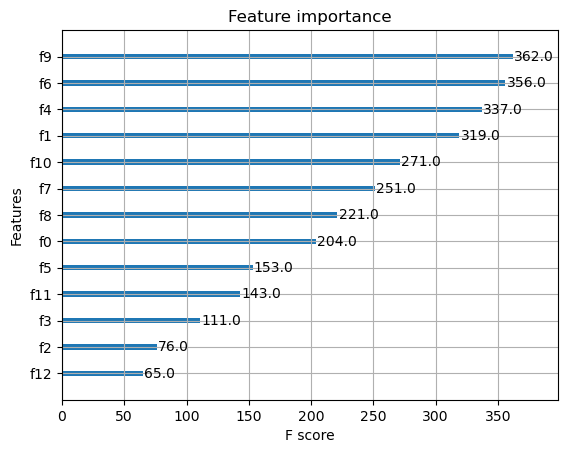

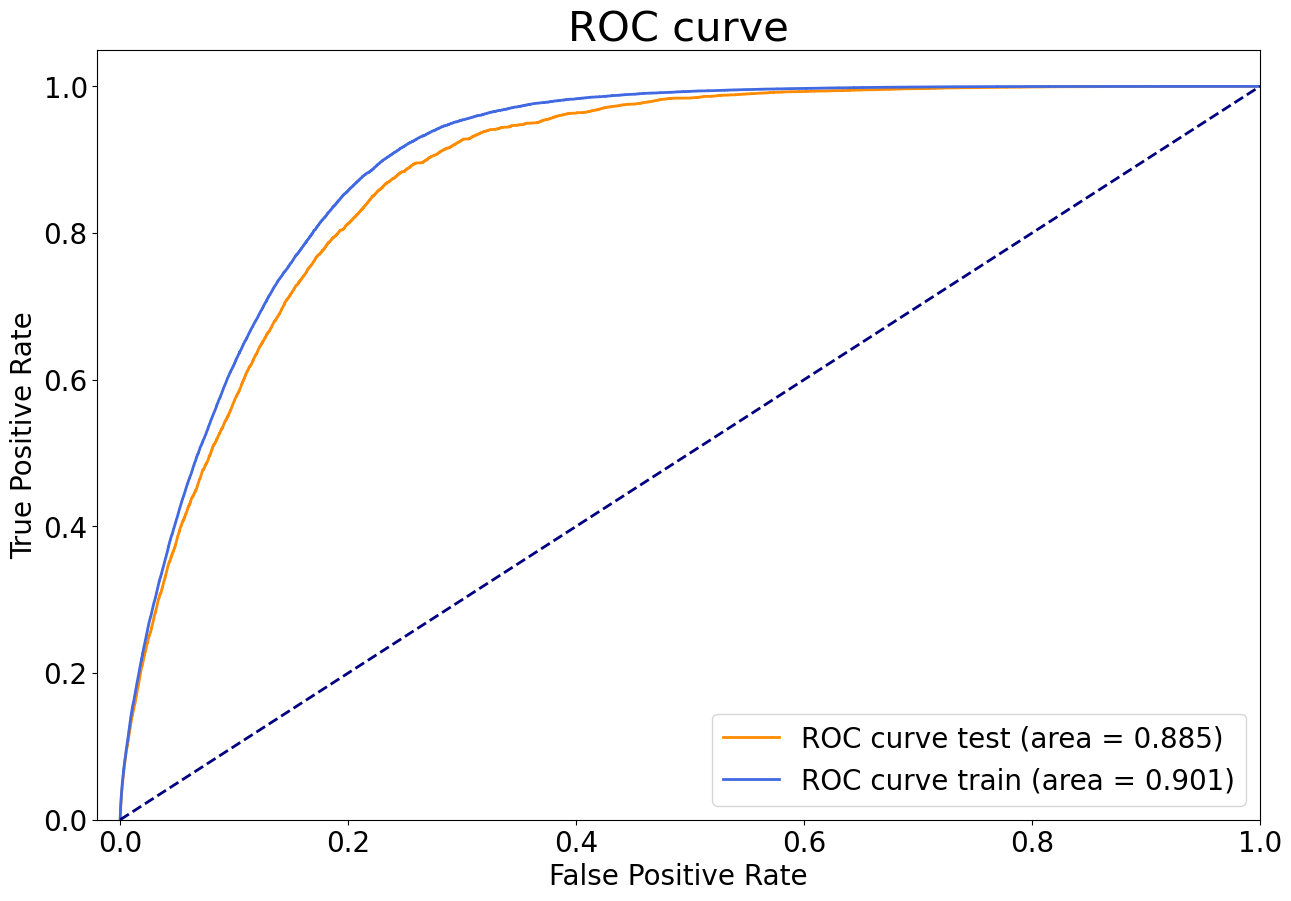

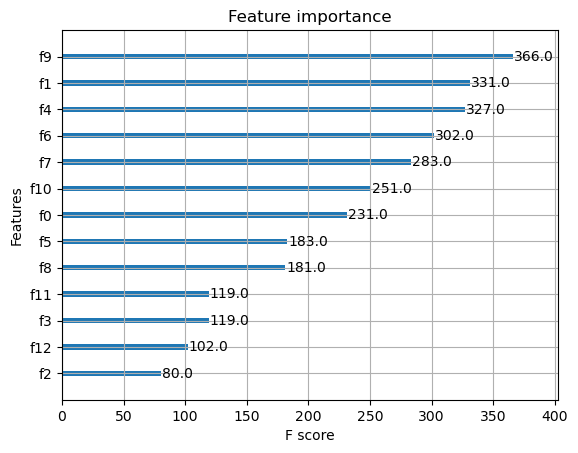

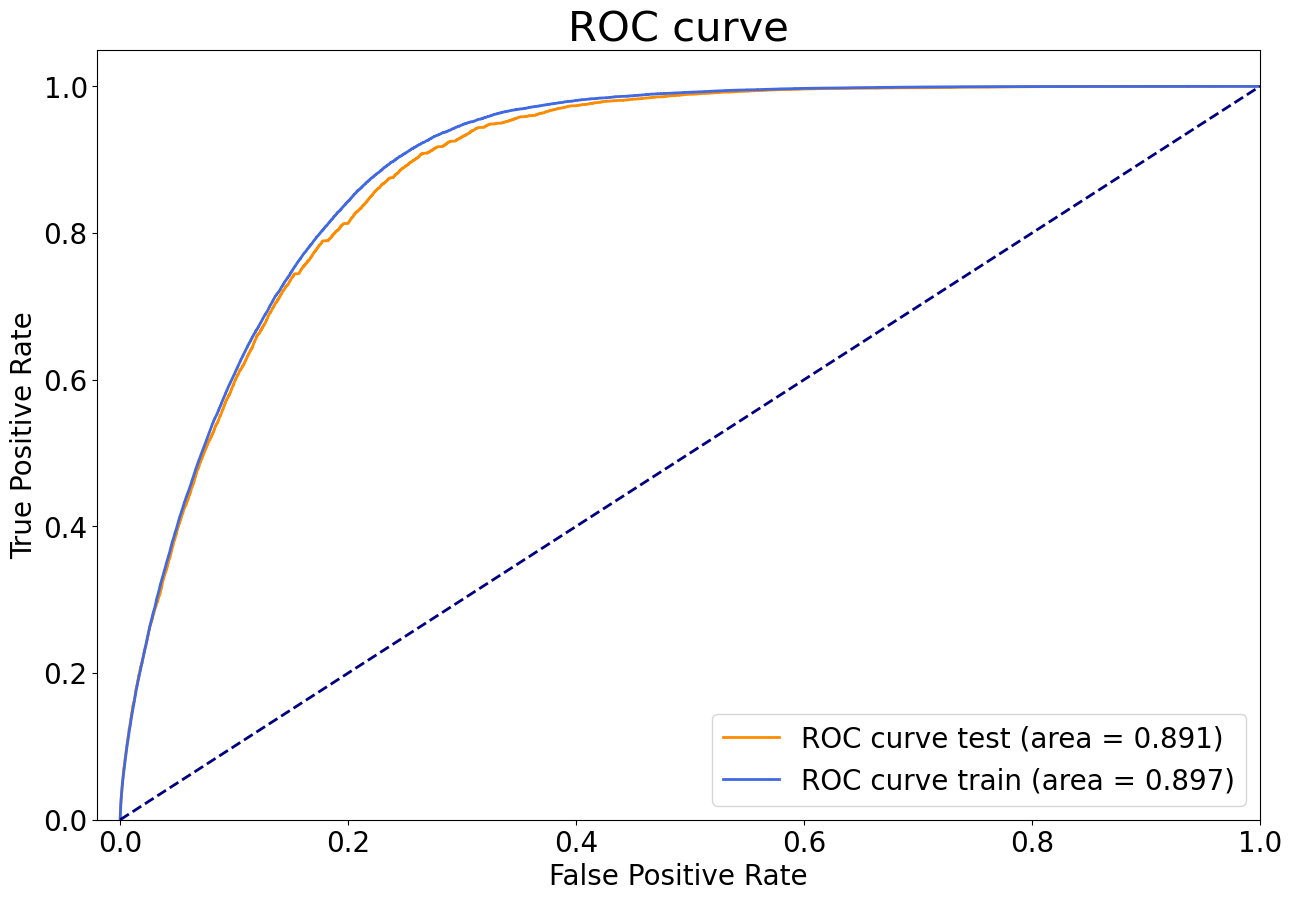

In [20]:
# Compute micro-average ROC curve and ROC area
for i, MC in enumerate(MC_events_kfold): 
    fpr, tpr, _ = roc_curve(MC[events_test[i]]["label"], check[i], sample_weight=abs(MC[events_test[i]]["weight"]))
    fpr_train, tpr_train, _train = roc_curve(MC[events_train[i]]["label"], check_train[i], sample_weight=abs(MC[events_train[i]]["weight"]))
    roc_auc = auc(fpr, tpr)
    roc_auc_train = auc(fpr_train, tpr_train)
    xgboost.plot_importance(bdt[i])
    lw = 2
    fig = plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve test (area = %0.3f)' % roc_auc)
    plt.plot(fpr_train, tpr_train, color='royalblue',
             lw=lw, label='ROC curve train (area = %0.3f)' % roc_auc_train)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('ROC curve', fontsize=30)
    plt.legend(loc="lower right", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.show()
    #if not SAVE: 
    fig.savefig(f"plots/ROC_{i}.pdf")

In [22]:
del features_train 
del features_test 
del d_train 
del d_test 

# Predict

In [23]:
for i, MC in enumerate(MC_events_kfold):
    features = awkward.to_numpy(MC[bdt_config["features"]])
    features = features.view((float, len(features.dtype.names)))
    if i == 0:
        MC["mva_score"] = bdt[1].predict(xgboost.DMatrix(features))
    else:
        MC["mva_score"] = bdt[0].predict(xgboost.DMatrix(features))


In [24]:
features = awkward.to_numpy(MC_events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
bdt_score_0 = bdt[1].predict(xgboost.DMatrix(features))
bdt_score_1 = bdt[0].predict(xgboost.DMatrix(features))

MC_events["mva_score"] = ak.where(
    MC_events.event % 2 == 0,
    bdt_score_0,
    bdt_score_1
)


# Rescale the train QCD to its original weight
Here we go back to the correct normalisation for QCD and weight with negative sign

In [25]:
var = "LeadPhoton_pt_mgg"
var2 = "SubleadPhoton_pt_mgg"

for i, MC in enumerate(MC_events_kfold):
        MC[events_train[i]]["weight"] = awkward.where(
                    MC[events_train[i]].proc_id != -3,
                    MC[events_train[i]].weight,
                    MC[events_train[i]].weight * 30
            )
        sf = ceval["abs_to_nominal"].evaluate(MC[var], MC[var2])
        MC[events_train[i]]["weight"] = awkward.where(
                    MC[events_train[i]]["label"] == 1,
                    MC[events_train[i]].weight / sf[events_train[i]],
                    MC[events_train[i]].weight
            )
        MC["square_weight"] = MC.weight ** 2

Here I add a branch that helps with erros in the histograms, there probably is a smarter way 

In [26]:
MC_events["square_weight"] = MC_events.weight ** 2

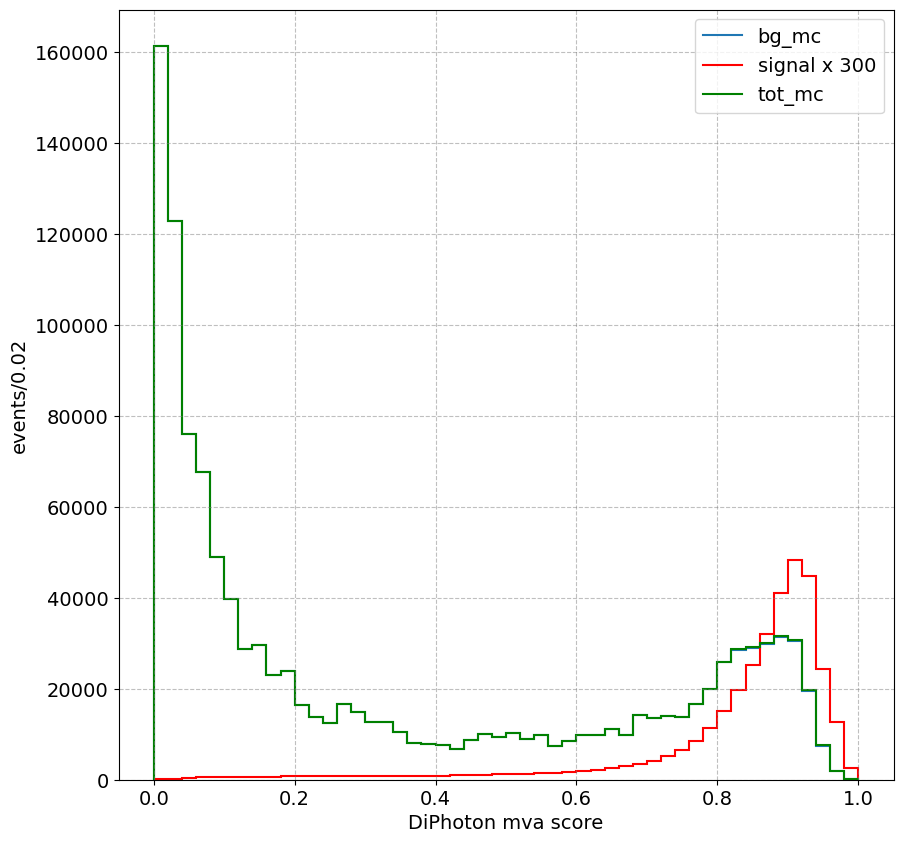

<Figure size 640x480 with 0 Axes>

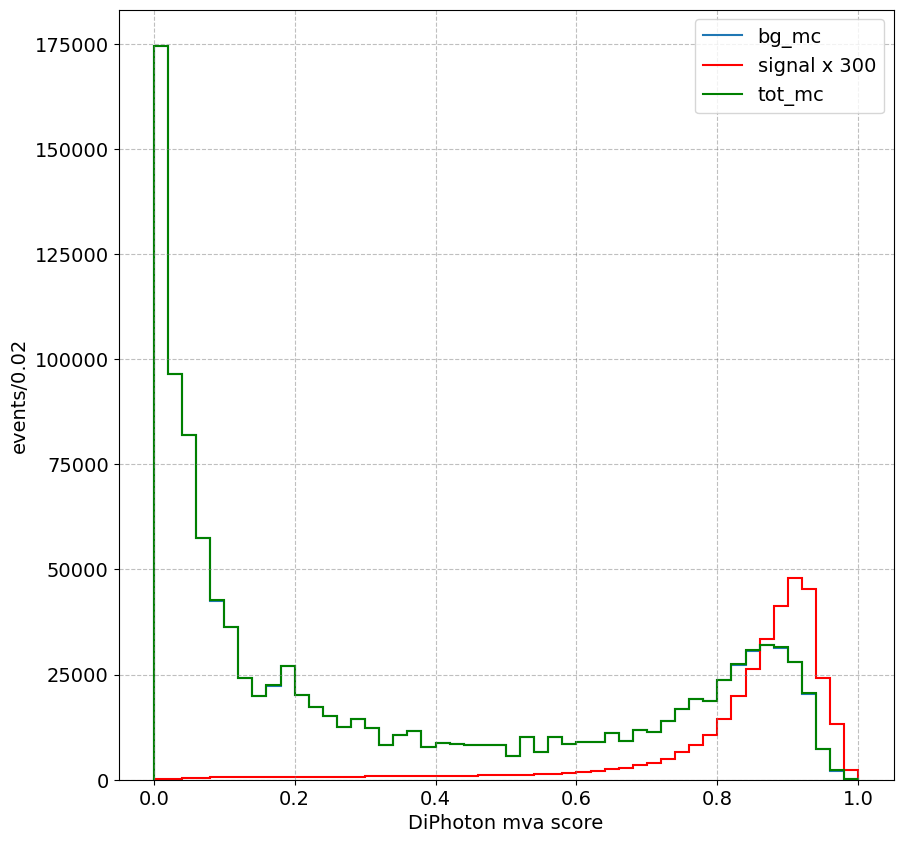

<Figure size 640x480 with 0 Axes>

In [27]:
#bdt_score
for i, MC in enumerate(MC_events_kfold):
    fig, axs = plt.subplots(1,1, figsize=(10, 10))
    min_ = 0
    max_ = 1
    nbins = 50
    h_bdt_score_tot = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_sig = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_bg = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
    h_bdt_score_tot.fill(bdt_score_tot = MC.mva_score, weight = MC.weight)
    h_bdt_score_tot_err.fill(bdt_score_tot = MC.mva_score, weight = MC.square_weight)
    h_bdt_score_sig.fill(bdt_score_tot = MC.mva_score[(MC.proc_id > 0)], weight = MC.weight[(MC.proc_id > 0)])
    h_bdt_score_bg.fill( bdt_score_tot = MC.mva_score[(MC.proc_id < 0)], weight = MC.weight[(MC.proc_id < 0)])

    h_bdt_score_sig = h_bdt_score_sig * 300

    h_bdt_score_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
    h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
    h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")


    axs.legend( prop={'size': 14})
    axs.grid(color='grey', linestyle='--', alpha=0.5)
    axs.set_ylabel('events')
    axs.set_xlabel('DiPhoton mva score', fontsize=14)
    axs.set_ylabel('events/0.02', fontsize=14)
    axs.tick_params(axis='x', labelsize=14)
    axs.tick_params(axis='y', labelsize=14)

    plt.plot()
    plt.show()
    plt.savefig("plots/mva_score_sig_bg.pdf")

In [28]:
MC_events["weight"][MC_events.proc_id==-3] 

<Array [903, 918, 903, 902, ... 413, 412, 408] type='916 * ?float64'>

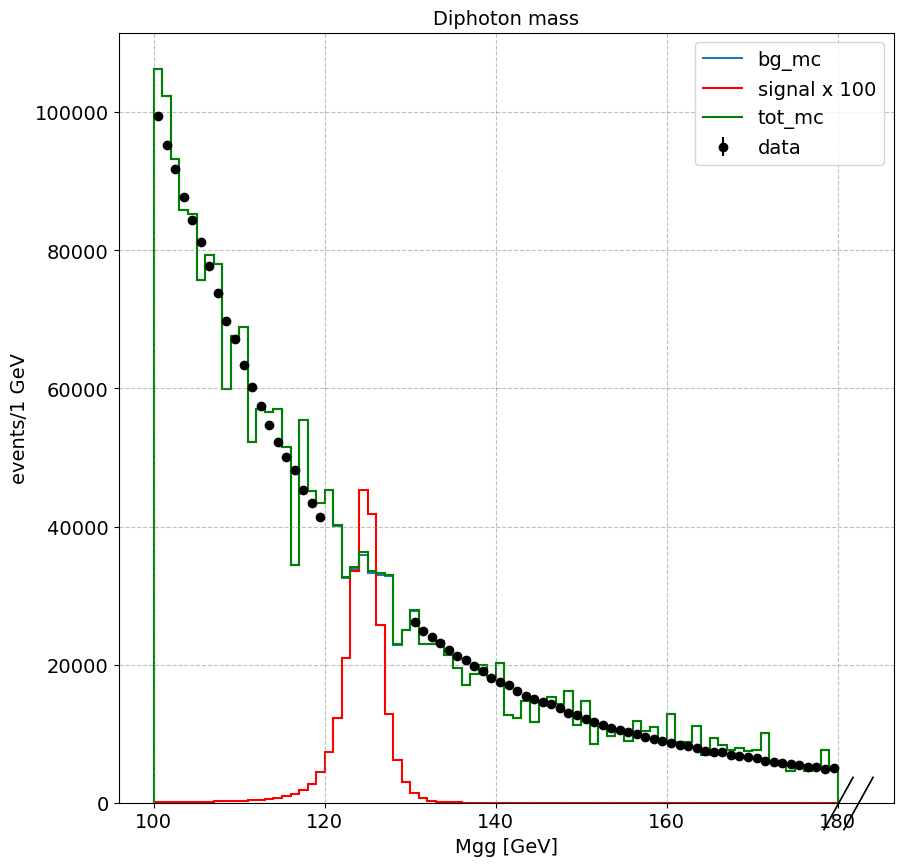

In [29]:
#bdt_score
fig, axs = plt.subplots(1,1, figsize=(10, 10))
min_ = 100
max_ = 180
nbins = 80
h_mass_tot = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_tot_err = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_sig = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_bg = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_tot.fill(bdt_score_tot = MC_events.CMS_hgg_mass, weight = MC_events.weight)
h_mass_sig.fill(bdt_score_tot = MC_events.CMS_hgg_mass[MC_events.proc_id > 0], weight = MC_events.weight[MC_events.proc_id > 0])
h_mass_bg.fill( bdt_score_tot = MC_events.CMS_hgg_mass[MC_events.proc_id < 0], weight = MC_events.weight[MC_events.proc_id < 0])

h_mass_sig = h_mass_sig * 100

h_mass_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
h_mass_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 100")
h_mass_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")

h_mass_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_mass_data.fill(bdt_score_tot=data_events.CMS_hgg_mass, weight=data_events.weight)

bins_data, edges_data = h_mass_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")

axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)
axs.set_ylabel('events')
axs.set_title('Diphoton mass', fontsize=14)
axs.set_xlabel('Mgg [GeV]', fontsize=14)
axs.set_ylabel('events/1 GeV', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()
if SAVE: 
    fig.savefig("plots/mgg_sig_bg.pdf")

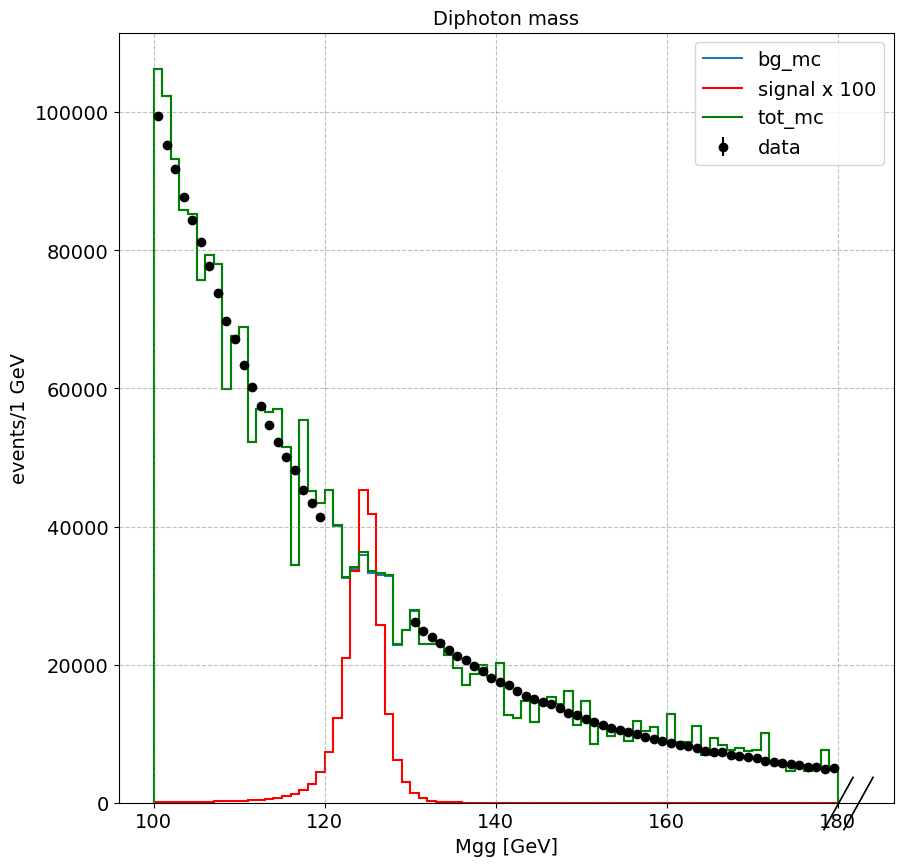

In [30]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))
min_ = 100
max_ = 180
nbins = 80
h_mass_tot = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_tot_err = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_sig = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_bg = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))

for i, MC in enumerate(MC_events_kfold):
    h_mass_tot.fill(bdt_score_tot = MC.CMS_hgg_mass, weight = MC.weight)
    h_mass_tot_err.fill(bdt_score_tot = MC.CMS_hgg_mass, weight = MC.square_weight)
    h_mass_sig.fill(bdt_score_tot = MC.CMS_hgg_mass[(MC.proc_id > 0)], weight = MC.weight[(MC.proc_id > 0)])
    h_mass_bg.fill( bdt_score_tot = MC.CMS_hgg_mass[(MC.proc_id < 0)], weight = MC.weight[(MC.proc_id < 0)])

h_mass_sig = h_mass_sig * 100


h_mass_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
h_mass_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 100")
h_mass_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")

h_mass_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_mass_data.fill(bdt_score_tot=data_events.CMS_hgg_mass, weight=data_events.weight)

bins_data, edges_data = h_mass_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")

axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)
axs.set_ylabel('events')
axs.set_title('Diphoton mass', fontsize=14)
axs.set_xlabel('Mgg [GeV]', fontsize=14)
axs.set_ylabel('events/1 GeV', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()

In [31]:
data_events.weight

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='2281324 * ?float64'>

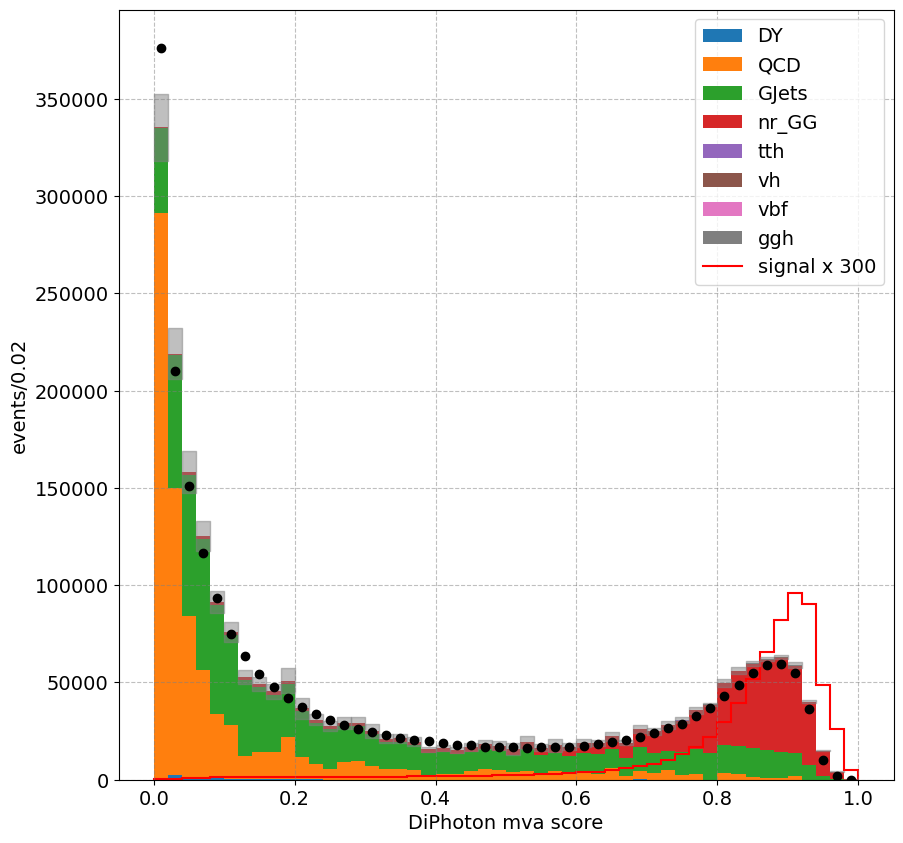

In [32]:
#bdt_score
fig, axs = plt.subplots(1,1, figsize=(10, 10))

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="bdt_score_tot")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "bdt_score_tot", label = "tot"))
h_bdt_score_tot = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))

#for i, MC in enumerate(MC_events_kfold):
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 2)], weight=MC_events.weight[(MC_events.proc_id == 2)], c="ggh")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 3)], weight=MC_events.weight[(MC_events.proc_id == 3)], c="tth")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 4)], weight=MC_events.weight[(MC_events.proc_id == 4)], c="vbf")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)], c="vh")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -1)], weight=MC_events.weight[(MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -2)], weight=MC_events.weight[(MC_events.proc_id == -2)], c="GJets")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="QCD")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -4)], weight=MC_events.weight[(MC_events.proc_id == -4)], c="DY")

h_bdt_score_tot.fill(bdt_score_tot = MC_events.mva_score, weight = MC_events.weight)
h_bdt_score_tot_err.fill(bdt_score_tot = MC_events.mva_score, weight = MC_events.square_weight)
h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=axs, stack=True, histtype="fill")

h_bdt_score_sig = hist.Hist(hist.axis.Regular(bins=nbins, start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)])
h_bdt_score_sig = h_bdt_score_sig * 300
h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

mc["bins"]["tot"] = h_bdt_score_tot.to_numpy()[0]
mc["edges"]["tot"] = h_bdt_score_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_bdt_score_tot_err.to_numpy()[0])

ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    axs.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

features = awkward.to_numpy(data_events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
data_events["mva_score"] = bdt[0].predict(xgboost.DMatrix(features))

h_bdt_score_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_data.fill(bdt_score_tot=data_events.mva_score, weight=data_events.weight)

bins_data, edges_data = h_bdt_score_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
axs.set_ylabel('events')
axs.set_xlabel('DiPhoton mva score', fontsize=14)
axs.set_ylabel('events/0.02', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/mva_score_sig_bg_stack.pdf")

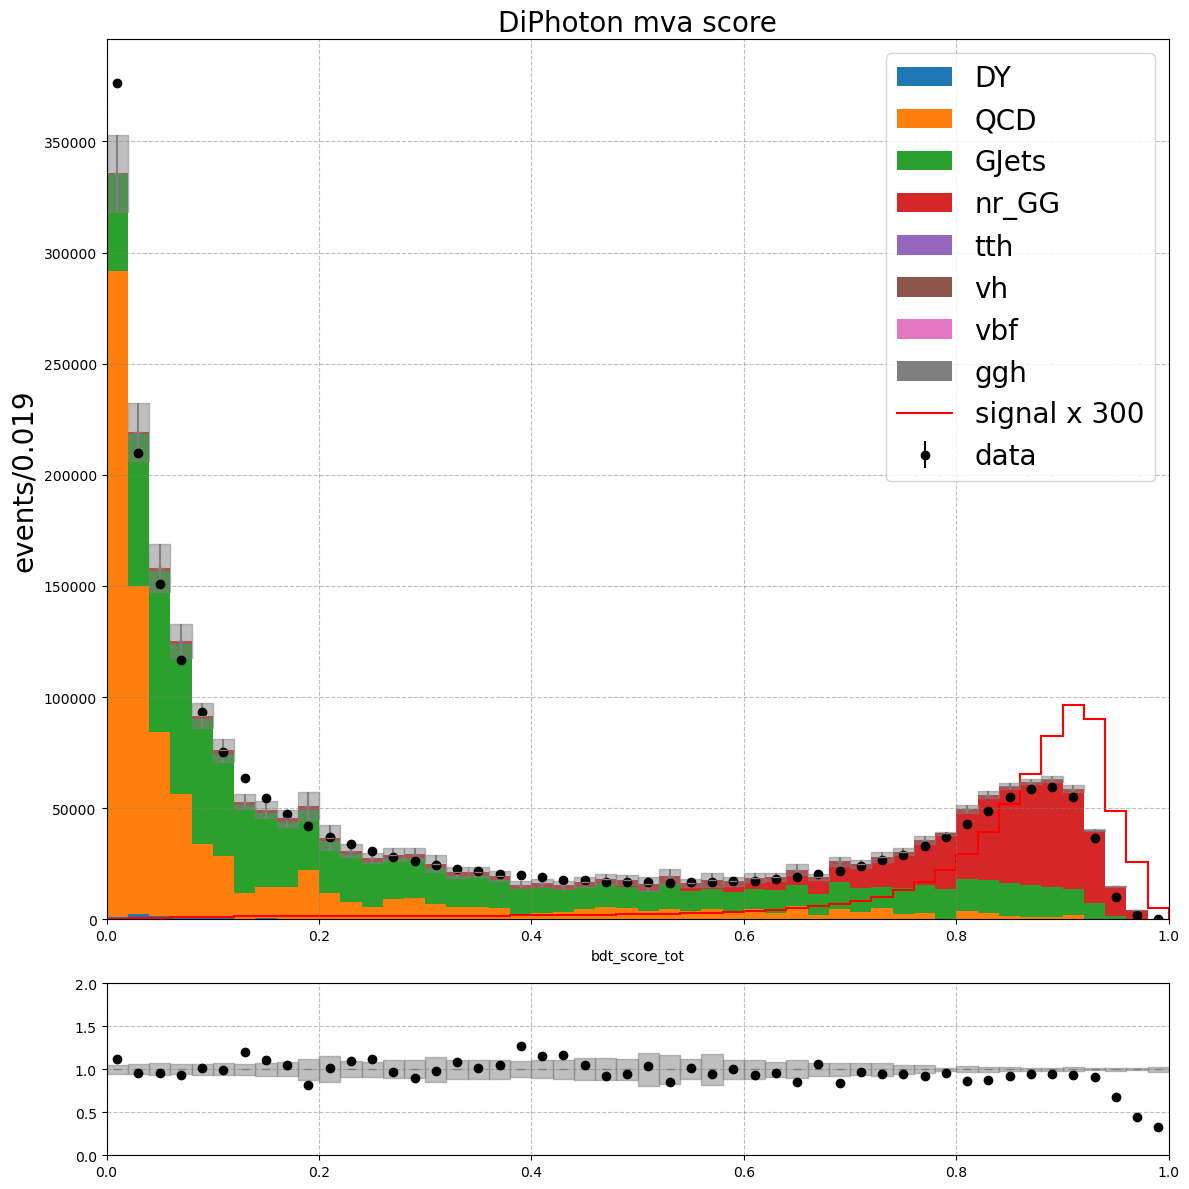

In [33]:
# plot it
#print(full_hist)
fig = plt.figure(figsize=(12, 12))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)
ax0.errorbar(edges_data[dump], bins_data, yerr=bins_err, color="black", marker="o", linestyle="", label="data")
h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_bdt_score_sig.project("bdt_score_tot").plot(ax=ax0, color="red", label="signal x 300")
 
ax0.set_ylabel('events')
ax0.set_title('DiPhoton mva score', fontsize=20)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)


ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)

ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 20})
ax0.grid(color='grey', linestyle='--', alpha=0.5)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.plot(mc["edges"]["tot"][:-1], mc["bins"]["tot"]/mc["bins"]["tot"], color="grey", marker="_", linestyle="", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], bins_data / mc["bins"]["tot"], yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

# center the bins
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
ax0.set_ylabel(f'events/{str(2 * half_bin)[:5]}', fontsize=20)
ax1.set_ylim([0,2])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
plt.tight_layout()
plt.savefig("plots/mva_score_sig_bg_stack_ratio.pdf")

# Train and test overlay

In [72]:
#bdt_score
min_ = 0
max_ = 1
nbins = 50

h_bdt_score_tot_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
for i, MC in enumerate(MC_events_kfold):
    val = 1 if i == 0 else 0


    h_bdt_score_tot_train.fill(bdt_score_tot = MC_events_kfold[i].mva_score[MC_events_kfold[i].train_split == 0], weight = MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 0]/sum(MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 0]))
    h_bdt_score_tot_err_train.fill(bdt_score_tot = MC_events_kfold[i].mva_score[MC_events_kfold[i].train_split == 0], weight = (MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 0]/sum(MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 0]))**2)
    h_bdt_score_sig_train.fill(bdt_score_tot = MC_events_kfold[i].mva_score[(MC_events_kfold[i].proc_id > 0) & (MC_events_kfold[i].train_split == 0)], weight = MC_events_kfold[i].weight[(MC_events_kfold[i].proc_id > 0) & (MC_events_kfold[i].train_split == 0)])

    h_bdt_score_tot_test.fill(bdt_score_tot = MC_events_kfold[i].mva_score[MC_events_kfold[i].train_split == 1], weight = MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 1]/sum(MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 1]))
    h_bdt_score_tot_err_test.fill(bdt_score_tot = MC_events_kfold[i].mva_score[MC_events_kfold[i].train_split == 1], weight = (MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 1]/sum(MC_events_kfold[i].weight[MC_events_kfold[i].train_split == 1]))**2)
    h_bdt_score_sig_test.fill(bdt_score_tot = MC_events_kfold[i].mva_score[(MC_events_kfold[i].proc_id > 0) & (MC_events_kfold[i].train_split == 1)], weight = MC_events_kfold[i].weight[(MC_events_kfold[i].proc_id > 0) & (MC_events_kfold[i].train_split == 1)])

    h_bdt_score_tot_val.fill(bdt_score_tot = MC_events_kfold[val].mva_score, weight=MC_events_kfold[val].weight/sum(MC_events_kfold[val].weight))
    h_bdt_score_tot_err_val.fill(bdt_score_tot = MC_events_kfold[val].mva_score, weight=(MC_events_kfold[val].weight/sum(MC_events_kfold[val].weight))**2)
    h_bdt_score_sig_val.fill(bdt_score_tot = MC_events_kfold[val].mva_score[(MC_events_kfold[val].proc_id > 0)], weight = MC_events_kfold[val].weight[(MC_events_kfold[val].proc_id > 0)])

    h_bdt_score_sig_train = h_bdt_score_sig * 300

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)
h_bdt_score_tot_train.project("bdt_score_tot").plot(ax=ax0, histtype="fill", color="red", alpha=0.4, label="training", linestyle="-", edgecolor="red")
h_bdt_score_tot_test.project("bdt_score_tot").plot(ax=ax0, histtype="fill", linestyle="-", color="royalblue", alpha=0.4, label="test", edgecolor="royalblue")
h_bdt_score_tot_val.project("bdt_score_tot").plot(ax=ax0, histtype="fill", linestyle="-", color="lawngreen", alpha=0.4, label="validation", edgecolor="lawngreen")
#h_bdt_score_tot_val.project("bdt_score_tot").plot(ax=ax0, histtype="fill", alpha=0.3)
#h_bdt_score_sig_train.project("bdt_score_tot").plot(ax=ax0, histtype="fill")
#h_bdt_score_sig_train.project("bdt_score_tot").plot(ax=ax0, color="red", label="signal x 300")

ax0.set_ylabel('events')
ax0.set_title('DiPhoton ID mva score', fontsize=15)
ax0.set_ylabel('events/0.02', fontsize=13)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
mc["bins"]["train"] = h_bdt_score_tot_train.to_numpy()[0]
mc["bins"]["test"] = h_bdt_score_tot_test.to_numpy()[0]
mc["bins"]["val"] = h_bdt_score_tot_val.to_numpy()[0]
mc["edges"]["train"] = h_bdt_score_tot_train.to_numpy()[1] + 0.01
mc["edges"]["test"] = h_bdt_score_tot_test.to_numpy()[1] + 0.01
mc["edges"]["val"] = h_bdt_score_tot_val.to_numpy()[1] + 0.01
mc["errs"]["train"] = np.sqrt(h_bdt_score_tot_err_train.to_numpy()[0])
mc["errs"]["test"] = np.sqrt(h_bdt_score_tot_err_test.to_numpy()[0])
mc["errs"]["val"] = np.sqrt(h_bdt_score_tot_err_val.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
yup = {}
ydn = {}
for set in ["train", "test", "val"]:
    ydn[set] = [mc["bins"][set][i] - x for i, x in enumerate(mc["errs"][set])]
    yup[set] = [mc["bins"][set][i] + x for i, x in enumerate(mc["errs"][set])]
ax0.errorbar(mc["edges"]["train"][:-1], mc["bins"]["train"], yerr=mc["errs"]["train"], color="red", marker="_", linestyle="")
ax0.errorbar(mc["edges"]["test"][:-1], mc["bins"]["test"], yerr=mc["errs"]["test"], color="royalblue", marker="_", linestyle="")
ax0.errorbar(mc["edges"]["val"][:-1], mc["bins"]["val"], yerr=mc["errs"]["val"], color="lawngreen", marker="_", linestyle="")
ax0.legend( prop={'size': 15})
ax0.grid(color='grey', linestyle='--', alpha=0.5)
ax1.grid(color='grey', linestyle='--', alpha=0.5)
colors = ["red", "royalblue", "lawngreen"]
for j, set in enumerate(["train", "test", "val"]):
    for i, x in enumerate(mc["edges"][set][:-1]):
        ax1.fill_between([x - 0.01, x + 0.01], [ydn[set][i]/mc["bins"]["train"][i], ydn[set][i]/mc["bins"]["train"][i]], [yup[set][i]/mc["bins"]["train"][i], yup[set][i]/mc["bins"]["train"][i]], facecolor=colors[j], alpha=0.3, edgecolor=colors[j], label="MC stat unc.")


ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["val"]/mc["bins"]["train"], yerr=abs(mc["errs"]["val"]/mc["bins"]["train"]), color="lawngreen", marker="+",linestyle="", label="training")
ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["train"]/mc["bins"]["train"], yerr=abs(mc["errs"]["train"]/mc["bins"]["train"]), color="red", marker="+",linestyle="", label="training")
ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["test"]/mc["bins"]["train"], yerr=abs(mc["errs"]["test"]/mc["bins"]["train"]), color="royalblue", marker="+",linestyle="", label="training")
#ax1.fill_between(mc["edges"]["val"][:-1], mc["bins"]["val"]/mc["bins"]["train"]-mc["errs"]["val"]/mc["bins"]["train"], mc["bins"]["val"]/mc["bins"]["train"] + mc["errs"["val"]/mc["bins"]["train"], facecolor='lawngreen', alpha=0.4)
#ax1.fill_between(mc["edges"]["train"][:-1], mc["bins"]["train"]/mc["bins"]["train"]-mc["errs"]["train"]/mc["bins"]["train"], mc["bins"]["train"]/mc["bins"]["train"] + m["errs"]["train"]/mc["bins"]["train"], facecolor='red', alpha=0.4)
#ax1.fill_between(mc["edges"]["test"][:-1], mc["bins"]["test"]/mc["bins"]["train"]-mc["errs"]["test"]/mc["bins"]["train"], mc["bins"]["test"]/mc["bins"]["train"] + m["errs"]["test"]/mc["bins"]["train"], facecolor='royalblue', alpha=0.4)

ax1.set_ylabel('ratio', fontsize=12)
ax1.set_ylim([0.5,1.5])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
plt.tight_layout()
plt.savefig("plots/mva_score_test_trai_ratio.pdf")


KeyboardInterrupt: 

In [ ]:
# Sigma RV
MC_events.fields

['dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_eta',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'LeadPhoton_pt',
 'LeadPhoton_energy',
 'LeadPhoton_energyErr',
 'LeadPhoton_energyRaw',
 'SubleadPhoton_energy',
 'SubleadPhoton_energyErr',
 'SubleadPhoton_energyRaw',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_eta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'n_jets',
 'weight',
 'proc_id',
 'label',
 'vtxProb',
 'mva_score',
 'square_weight']

In [ ]:
SB_MC = (MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)
SB_DATA = (data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)

/tmp/ipykernel_46163/3243815886.py:95: RuntimeWarning: invalid value encountered in divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_46163/3243815886.py:99: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_46163/3243815886.py:102: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


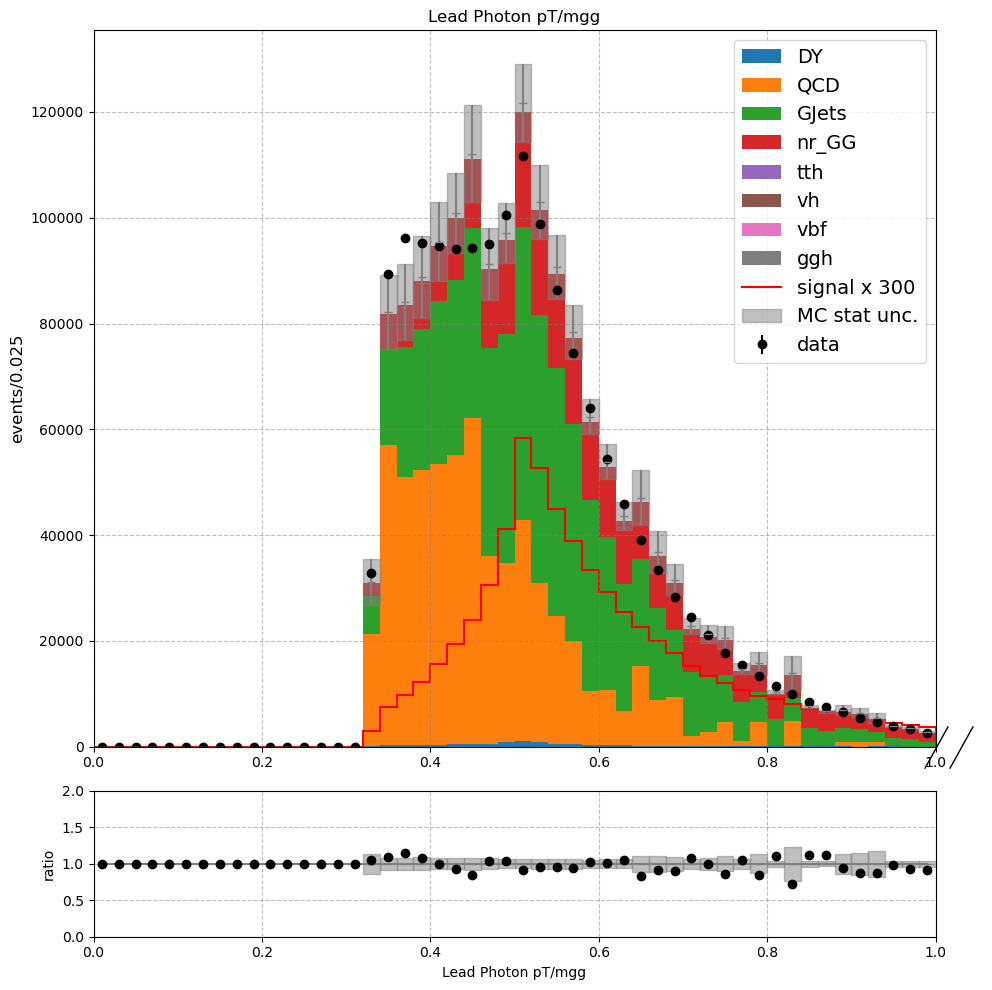

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="lead_pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -4)], c="DY")

h_lead_pt_mgg_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label = "tot"))
h_lead_pt_mgg_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label = "tot"))
h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label="tot"))

h_lead_pt_mgg_tot_err.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.square_weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_lead_pt_mgg_tot.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_lead_pt_mgg_sig.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_lead_pt_mgg_sig.project("lead_pt_mgg").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_lead_pt_mgg_tot.to_numpy()[0]
mc["edges"]["tot"] = h_lead_pt_mgg_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_lead_pt_mgg_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_lead_pt_mgg_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="lead_pt_mgg", label="tot"))
h_lead_pt_mgg_data.fill(lead_pt_mgg = data_events.LeadPhoton_pt_mgg[(data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)], weight = data_events.weight[(data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_lead_pt_mgg_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.025', fontsize=12)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon pT/mgg', fontsize=12)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0,2])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=10)
ax1.set_ylabel('ratio', fontsize=10)
plt.tight_layout()
    

if SAVE: fig.savefig("plots/lead_pt_mgg_sig_bg_stack.pdf")

KeyboardInterrupt: 

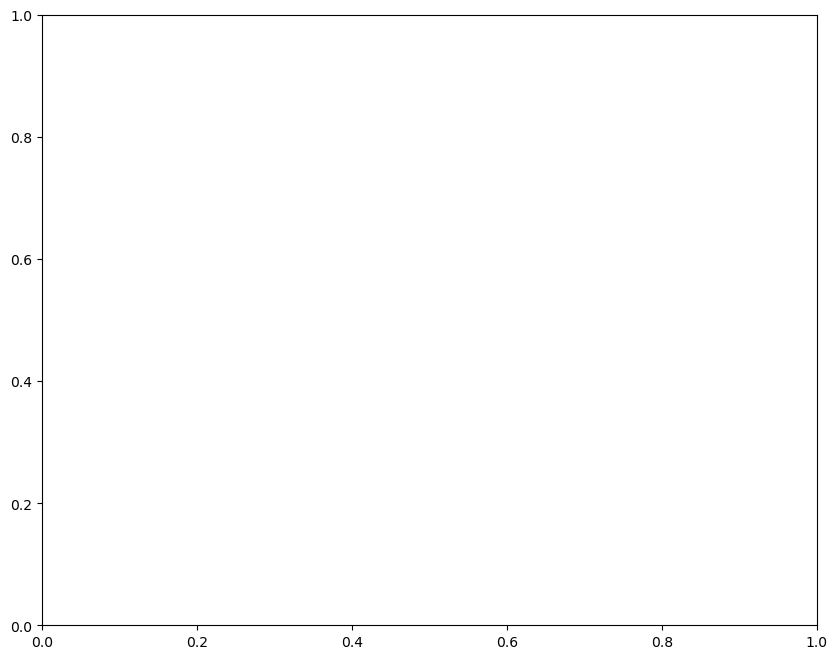

In [ ]:
# sublead photon pt/mgg
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0.2
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -4)], c="DY")

h_pt_mgg_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))
h_pt_mgg_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))
h_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))

h_pt_mgg_tot_err.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.square_weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_pt_mgg_tot.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_pt_mgg_sig.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_pt_mgg_sig.project("pt_mgg").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_pt_mgg_tot.to_numpy()[0]
mc["edges"]["tot"] = h_pt_mgg_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_pt_mgg_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_pt_mgg_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="lead_pt_mgg", label="tot"))
h_pt_mgg_data.fill(lead_pt_mgg = data_events.SubleadPhoton_pt_mgg[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_pt_mgg_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.02', fontsize=12)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon pT/mgg', fontsize=12)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.2,2])
ax1.set_xlim([0.2,1])
ax0.set_xlim([0.2,1])
ax1.set_xlabel('Sublead Photon pT/mgg', fontsize=10)
ax1.set_ylabel('ratio', fontsize=10)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/sublead_pt_mgg_sig_bg_stack.pdf")

/tmp/ipykernel_26056/3754840346.py:97: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/3754840346.py:101: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/3754840346.py:104: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


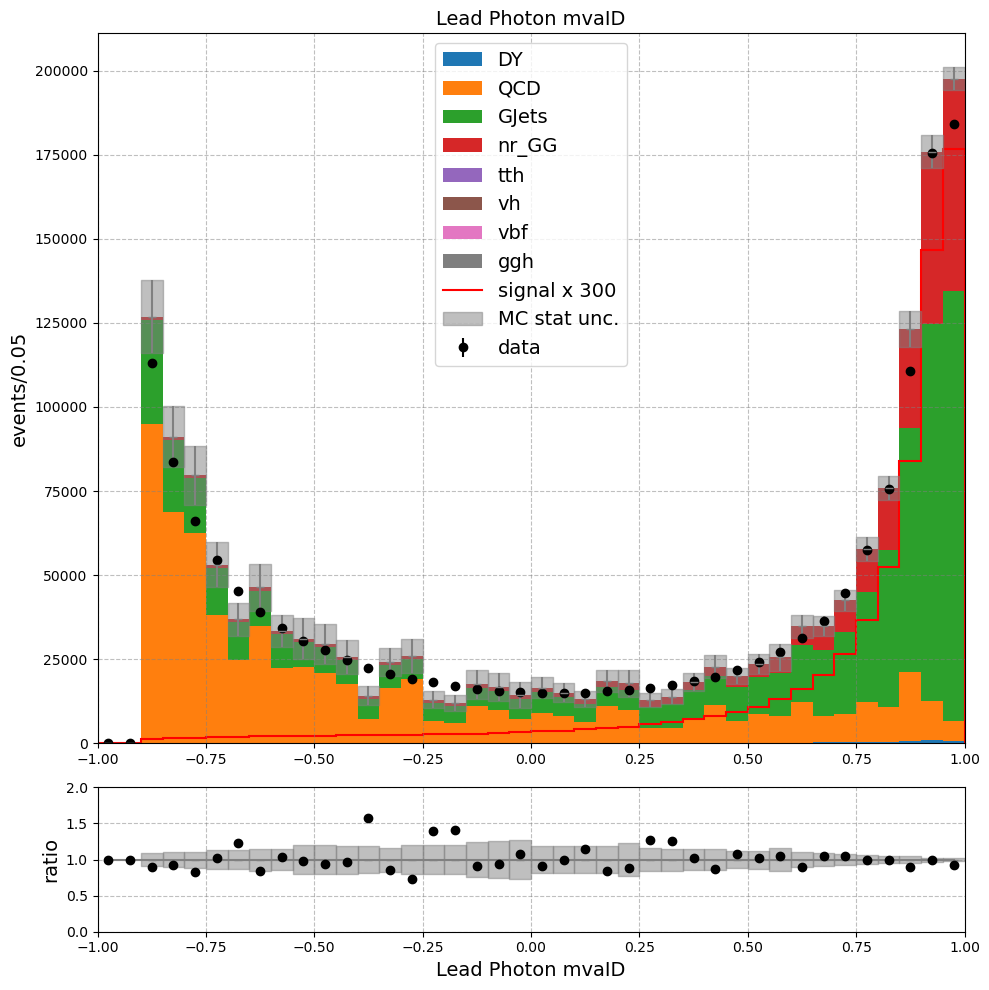

In [ ]:
# lead photon mvaID
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -1.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mva")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_mvaID_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))

h_mvaID_tot_err.fill(mva = MC_events.LeadPhoton_mvaID[SB_MC], weight = MC_events.square_weight[SB_MC])
h_mvaID_tot.fill(mva = MC_events.LeadPhoton_mvaID[SB_MC], weight = MC_events.weight[SB_MC])
h_mvaID_sig.fill(mva = MC_events.LeadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_mvaID_sig.project("mva").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_mvaID_tot.to_numpy()[0]
mc["edges"]["tot"] = h_mvaID_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_mvaID_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_mvaID_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_mvaID_data.fill(mva = data_events.LeadPhoton_mvaID[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_mvaID_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon mvaID', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([-1.,1])
ax0.set_xlim([-1.,1])
ax1.set_xlabel('Lead Photon mvaID', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/lead_mvaID_sig_bg_stack.pdf")

/tmp/ipykernel_26056/1788190032.py:97: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/1788190032.py:101: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/1788190032.py:104: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


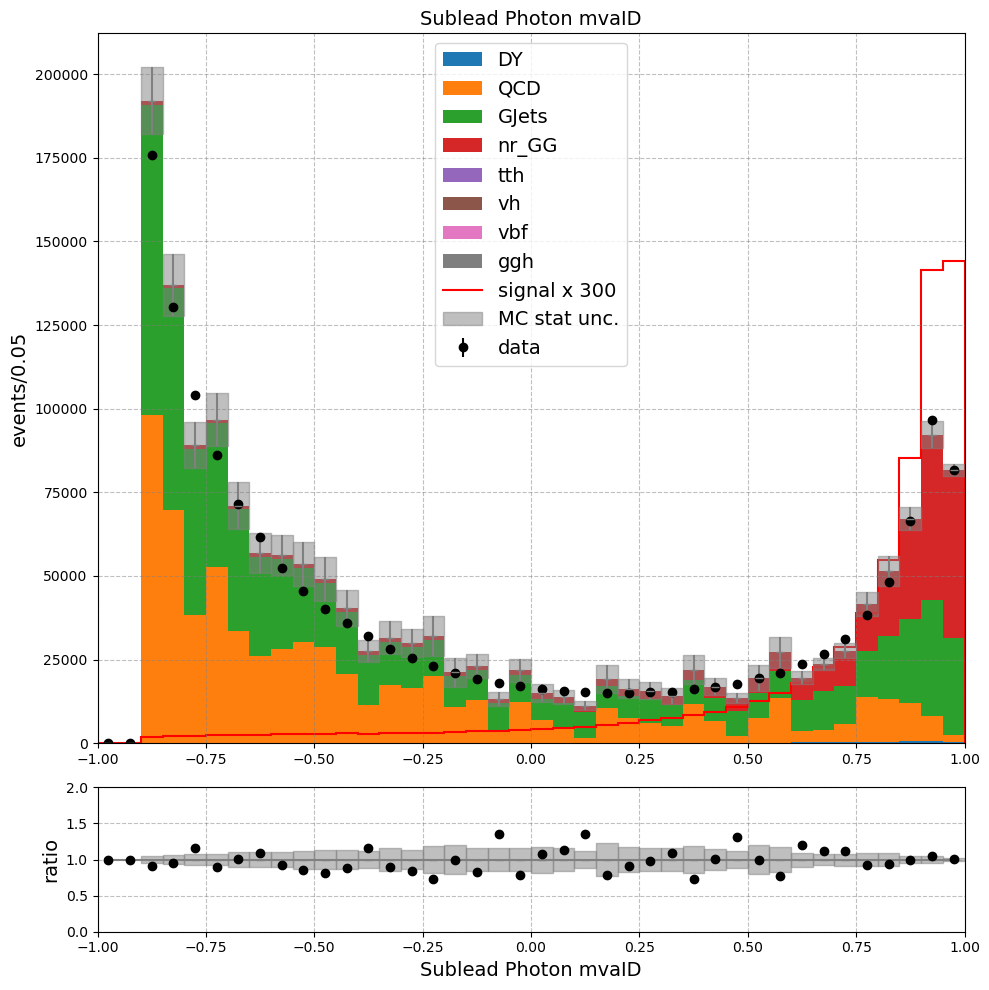

In [ ]:
# sublead photon mvaID
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -1.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mva")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_mvaID_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))

h_mvaID_tot_err.fill(mva = MC_events.SubleadPhoton_mvaID[SB_MC], weight = MC_events.square_weight[SB_MC])
h_mvaID_tot.fill(mva = MC_events.SubleadPhoton_mvaID[SB_MC], weight = MC_events.weight[SB_MC])
h_mvaID_sig.fill(mva = MC_events.SubleadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_mvaID_sig.project("mva").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_mvaID_tot.to_numpy()[0]
mc["edges"]["tot"] = h_mvaID_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_mvaID_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_mvaID_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_mvaID_data.fill(mva = data_events.SubleadPhoton_mvaID[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_mvaID_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon mvaID', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([-1.,1])
ax0.set_xlim([-1.,1])
ax1.set_xlabel('Sublead Photon mvaID', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/sublead_mvaID_sig_bg_stack.pdf")

/tmp/ipykernel_26056/702300971.py:97: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/702300971.py:101: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/702300971.py:104: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


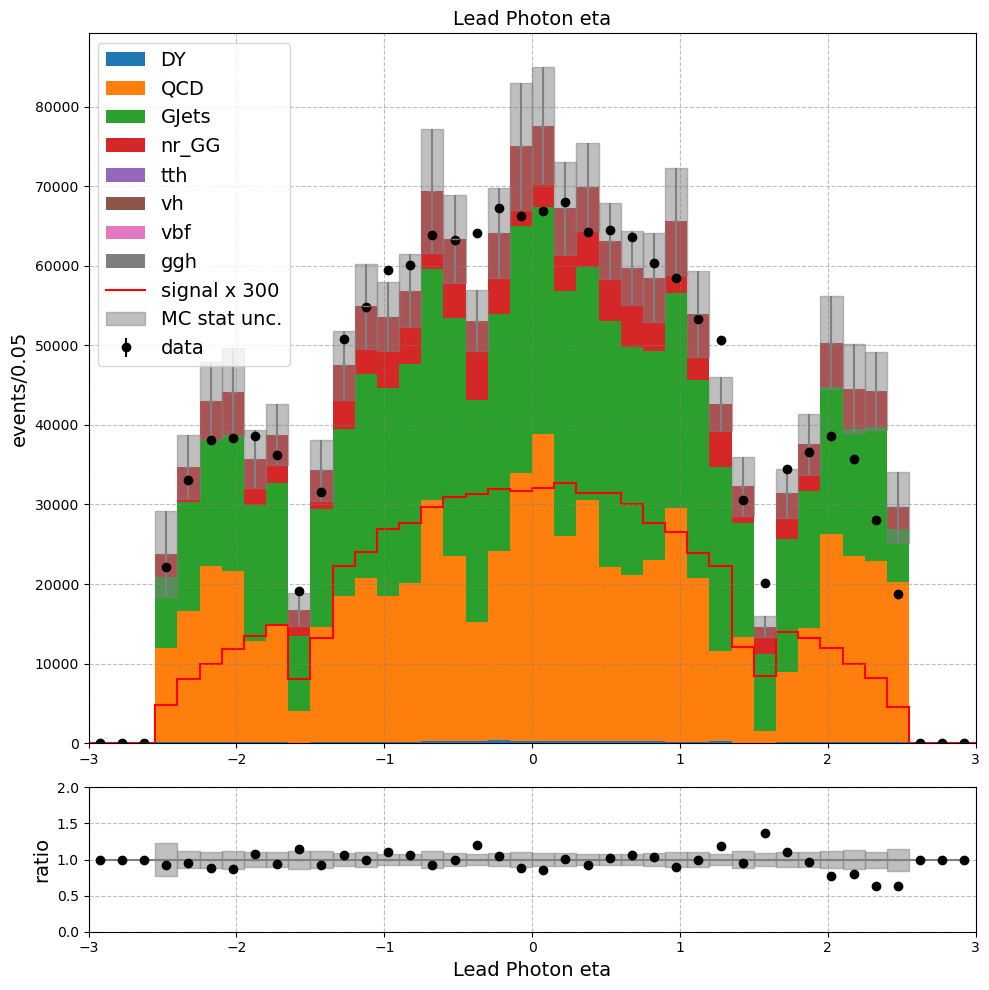

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_eta"
min_ = -3.
max_ = 3
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))

h_eta_tot_err.fill(eta = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(eta = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(eta = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project("eta").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_26056/2314754106.py:96: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/2314754106.py:100: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/2314754106.py:103: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


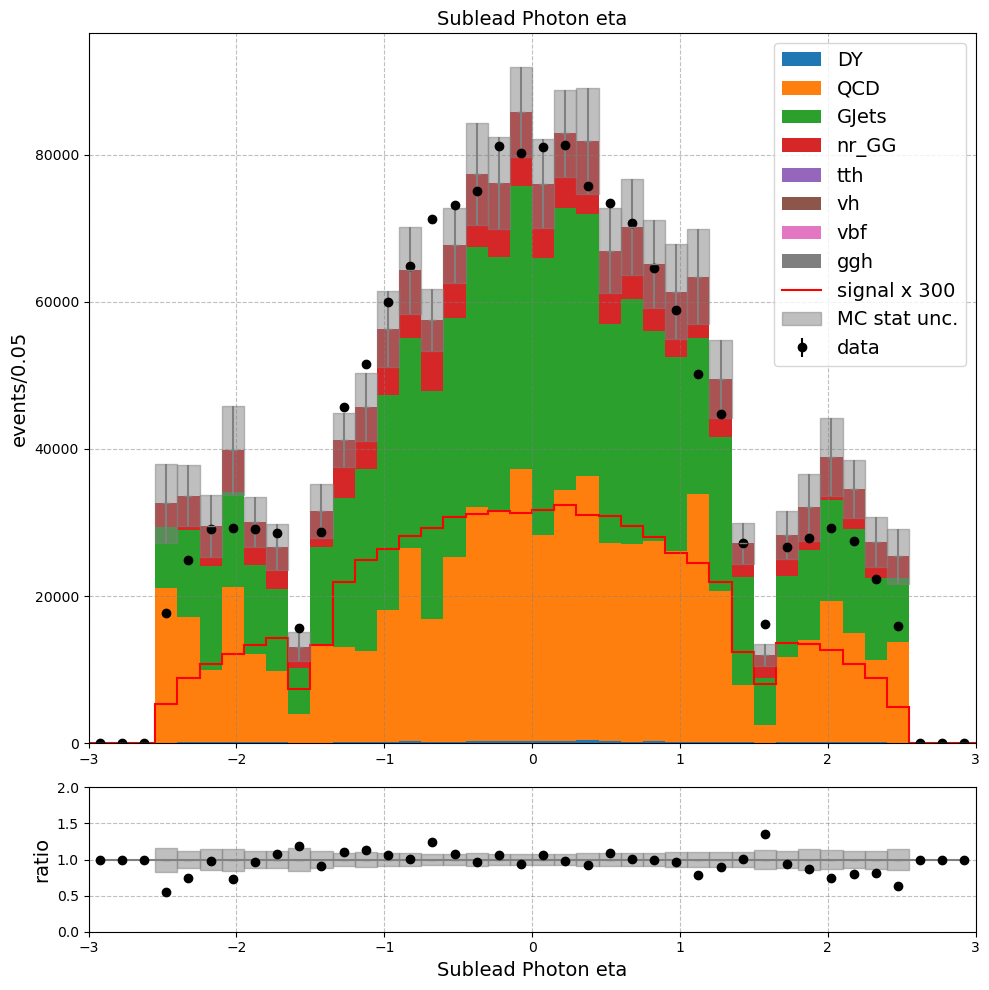

In [ ]:
# sublead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -3.
max_ = 3
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))

h_eta_tot_err.fill(eta = MC_events.SubleadPhoton_eta[SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(eta = MC_events.SubleadPhoton_eta[SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(eta = MC_events.SubleadPhoton_eta[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project("eta").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events.SubleadPhoton_eta[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sublead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/sublead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_26056/270810231.py:99: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/270810231.py:103: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/270810231.py:106: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


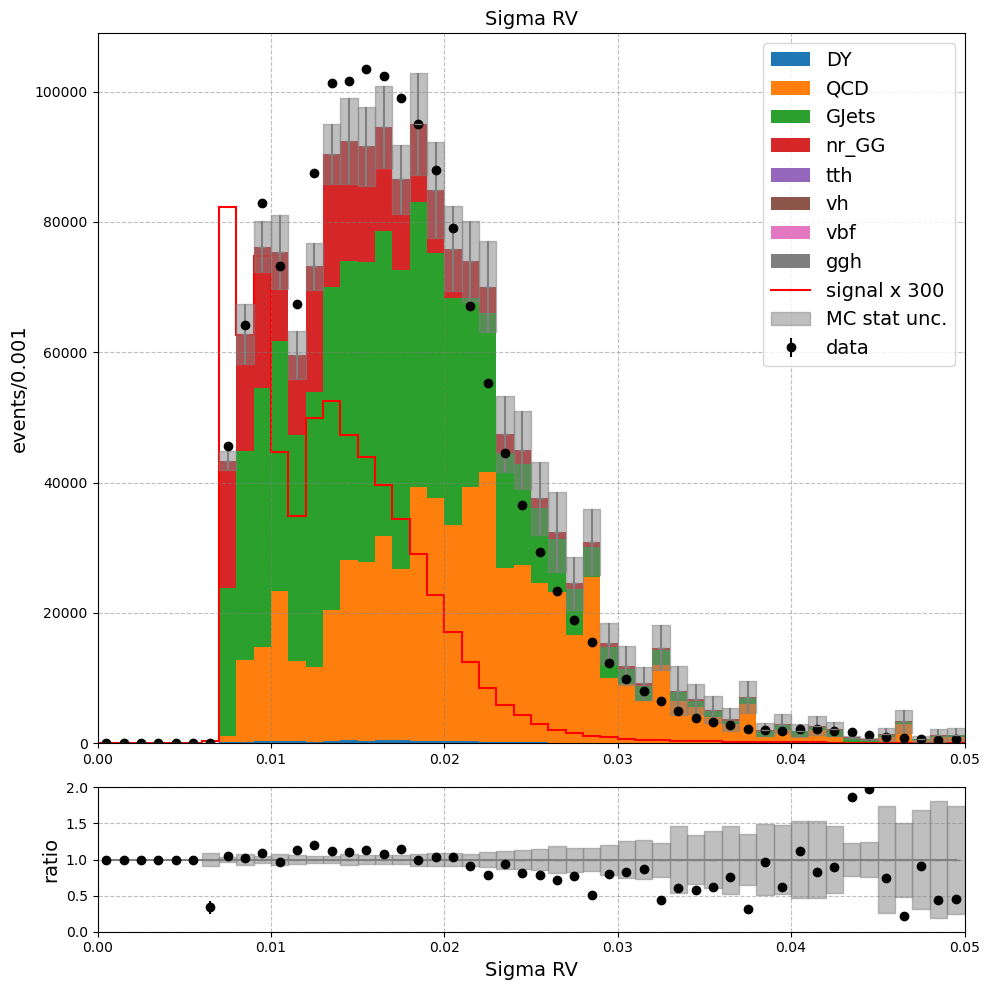

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMrv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")
#full_hist.fill(sigma = qcd[var], weight=qcd.weight_central*norm, c="QCD")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(sigma = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(sigma = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(sigma = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(sigma = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sigma RV', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sigma RV', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/sigmarv_sig_bg_stack.pdf")

/tmp/ipykernel_26056/3122605792.py:98: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/3122605792.py:102: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/3122605792.py:105: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


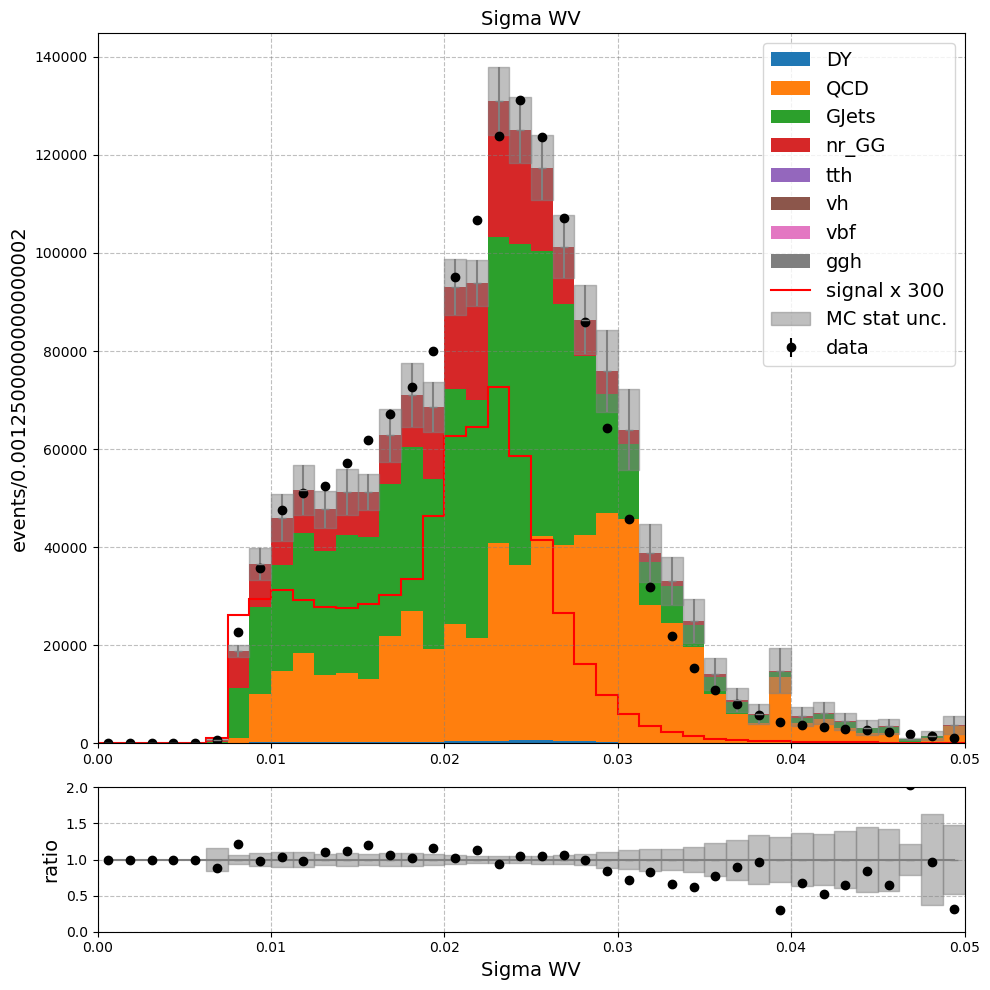

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMwv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(sigma = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(sigma = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(sigma = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(sigma = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sigma WV', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sigma WV', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/sigmawv_sig_bg_stack.pdf")

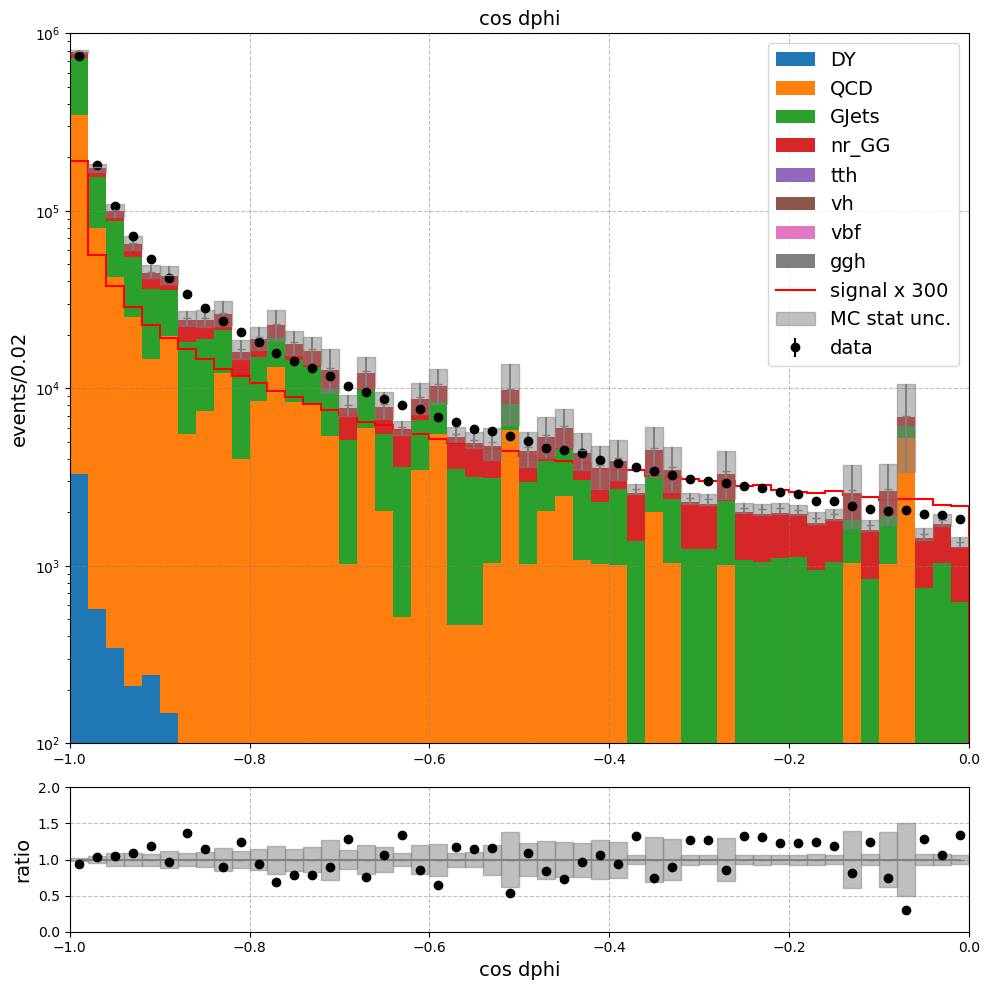

In [ ]:
# cos delta phi
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "Diphoton_cos_dPhi"
ax_name = "cosdphi"
min_ = -1
max_ = 0
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_cos_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_cos_tot_err.fill(cosdphi = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_cos_tot.fill(cosdphi = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_cos_sig.fill(cosdphi = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_cos_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_cos_tot.to_numpy()[0]
mc["edges"]["tot"] = h_cos_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_cos_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_cos_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_data.fill(cosdphi = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_cos_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('cos dphi', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax0.set_ylim([1e2,1e6])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax1.set_xlabel('cos dphi', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/cosdphi_sig_bg_stack.pdf")

/tmp/ipykernel_26056/1522817006.py:98: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/1522817006.py:102: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/1522817006.py:105: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


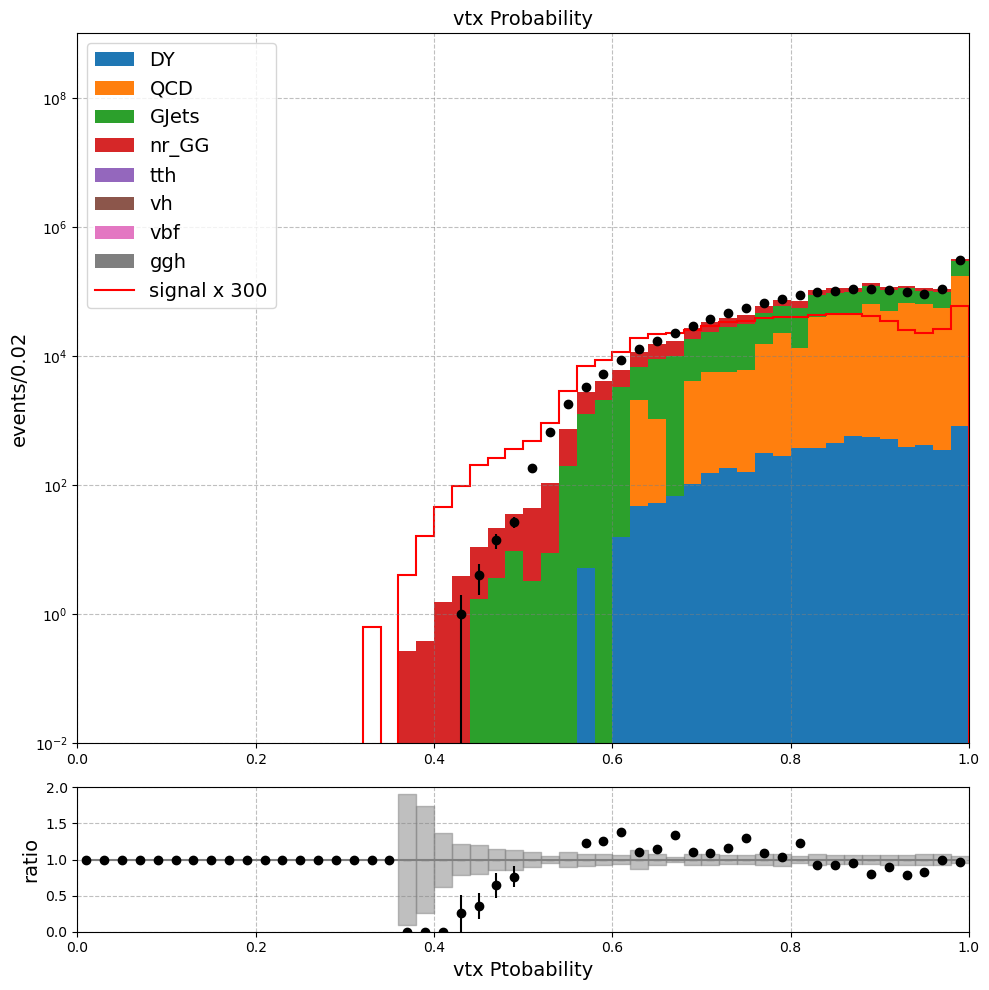

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "vtxProb"
ax_name = "vtx"
min_ = 0.
max_ = 1.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_vtx_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
#for i, x in enumerate(mc["edges"]["tot"][:-1]):
#    if i == 0:
#        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
#    else:
#        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('vtx Probability', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
#ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax0.set_ylim([1e-2,1e9])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax1.set_xlabel('vtx Ptobability', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/vtxprob_sig_bg_stack.pdf")

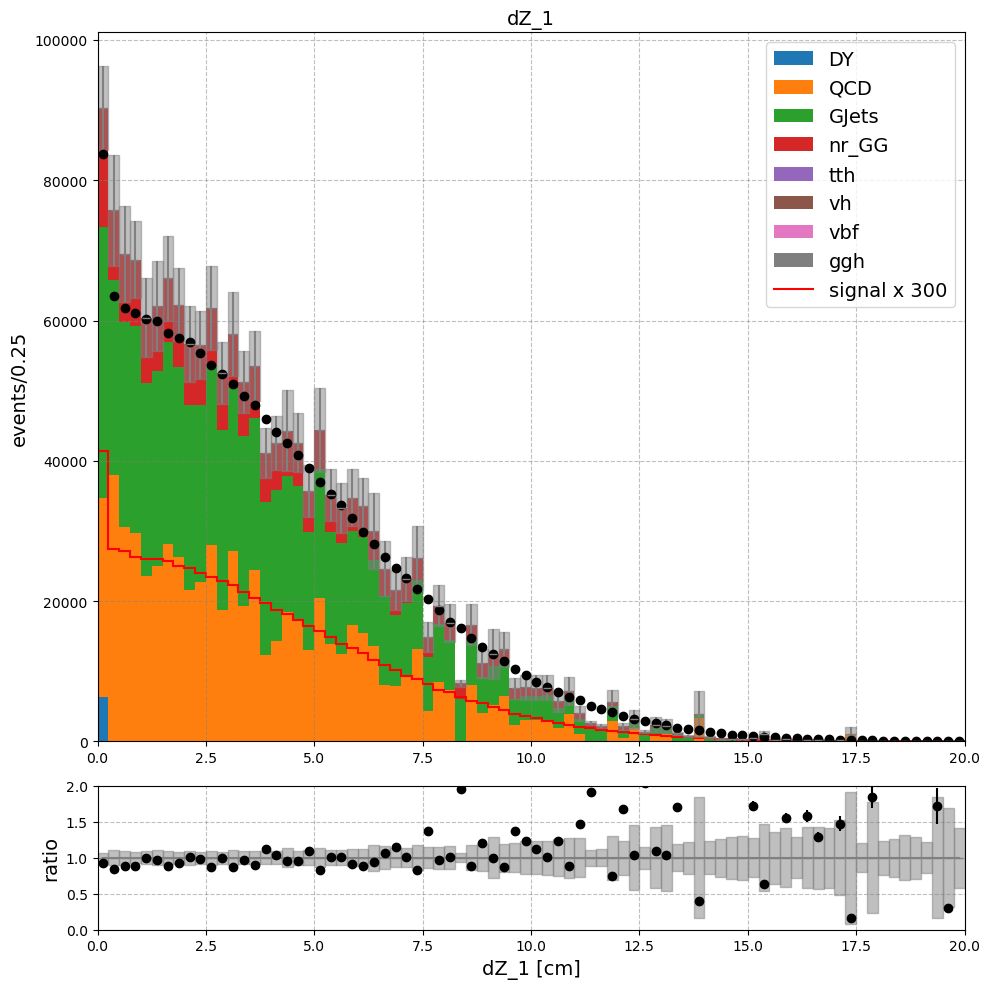

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dZ_1"
ax_name = "vtx"
min_ = 0.
max_ = 20.
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_vtx_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('dZ_1', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
#ax0.set_ylim([1e-2,1e9])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
#ax0.set_yscale('log')
ax1.set_xlabel('dZ_1 [cm]', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/dZ1_sig_bg_stack.pdf")

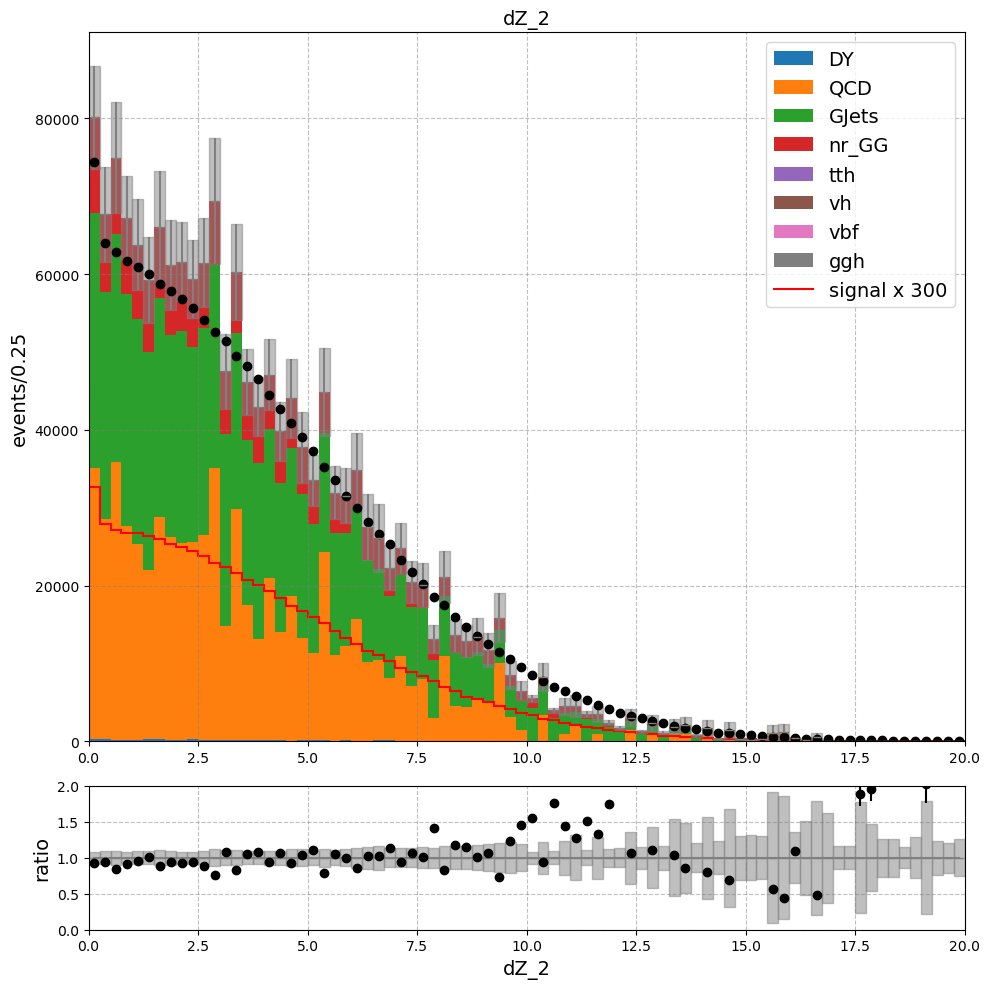

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dZ_2"
ax_name = "vtx"
min_ = 0.
max_ = 20.
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_vtx_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('dZ_2', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
#ax0.set_ylim([1e-2,1e9])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
#ax0.set_yscale('log')
ax1.set_xlabel('dZ_2', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/dZ2_sig_bg_stack.pdf")

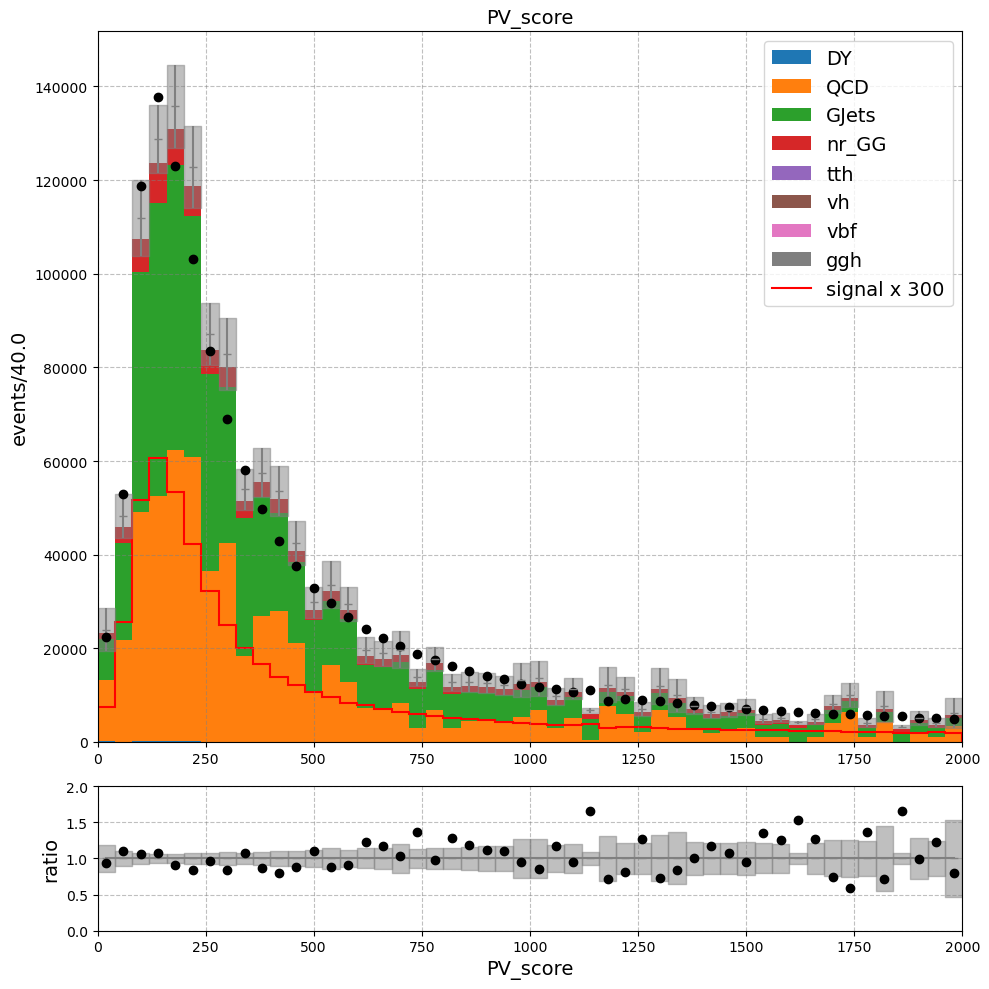

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "PV_score"
ax_name = "vtx"
min_ = 0.
max_ = 2000.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_vtx_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('PV_score', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
#ax0.set_ylim([1e-2,1e9])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
#ax0.set_yscale('log')
ax1.set_xlabel('PV_score', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/PV_Score_sig_bg_stack.pdf")

/tmp/ipykernel_26056/294555393.py:98: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_26056/294555393.py:102: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_26056/294555393.py:105: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


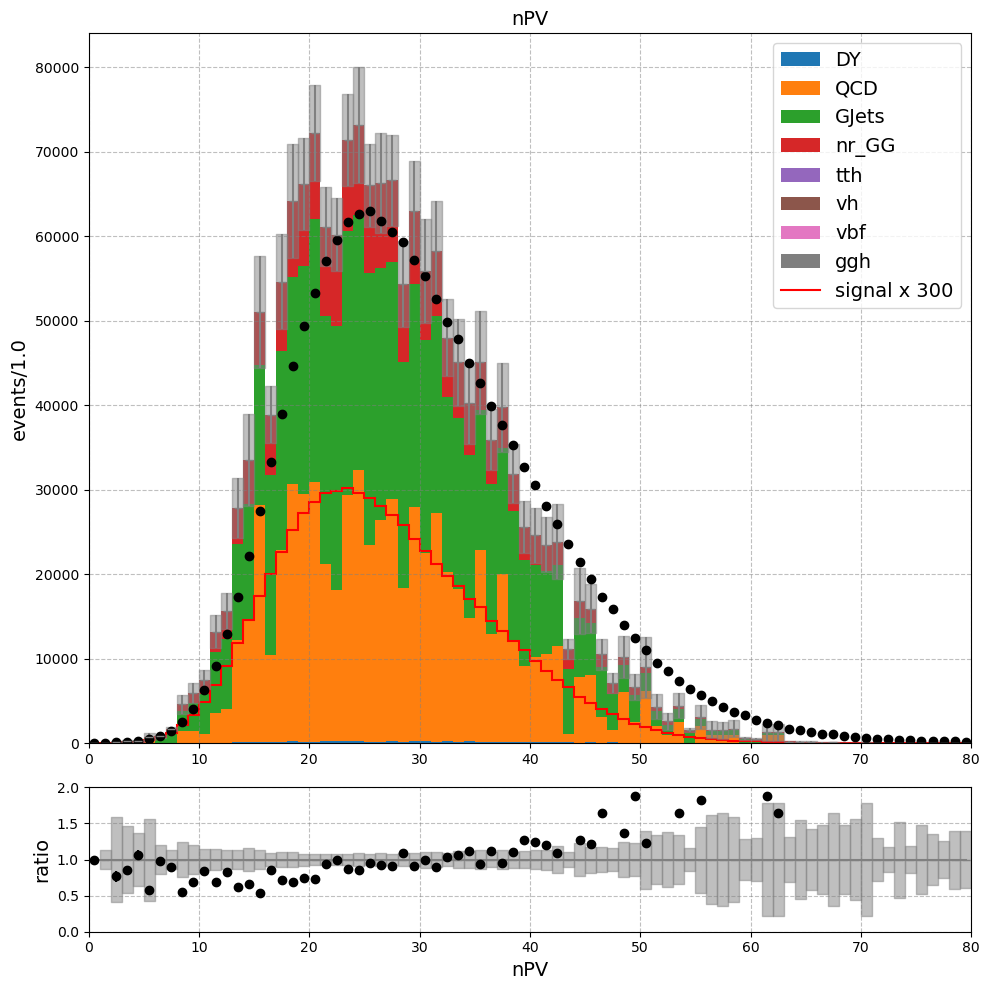

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "nPV"
ax_name = "vtx"
min_ = 0.
max_ = 80.
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -4)], c="DY")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_vtx_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('nPV', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('nPV', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/nPV_sig_bg_stack.pdf")

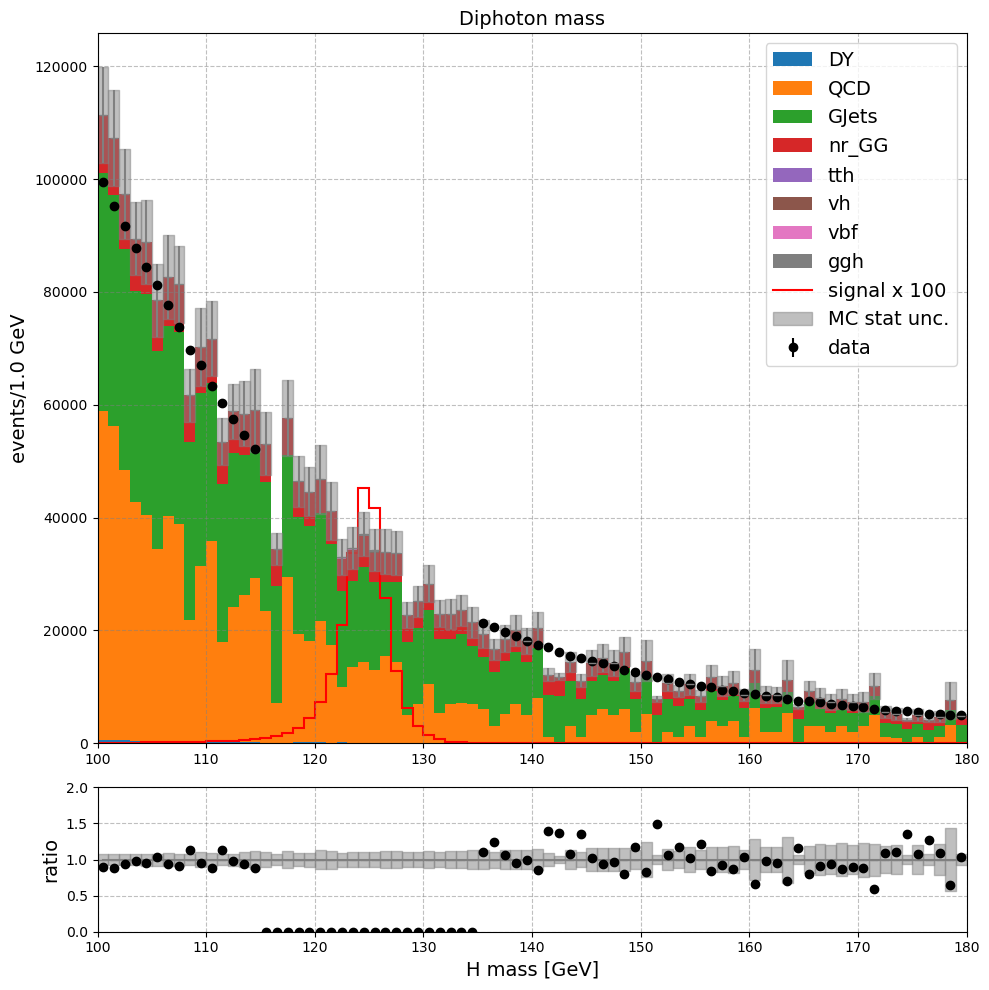

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "CMS_hgg_mass"
ax_name = "mass"
min_ = 100
max_ = 180
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD", "DY"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 2)], weight=MC_events.weight[(MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 3)], weight=MC_events.weight[(MC_events.proc_id == 3)], c="tth")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 4)], weight=MC_events.weight[(MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)], c="vh")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -1)], weight=MC_events.weight[(MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -2)], weight=MC_events.weight[(MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="QCD")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -4)], weight=MC_events.weight[(MC_events.proc_id == -4)], c="DY")


h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(mass = MC_events[var], weight = MC_events.square_weight)
h_eta_tot.fill(mass = MC_events[var], weight = MC_events.weight)
h_eta_sig.fill(mass = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 100)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 100")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(mass = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 115),(edges_data > 135))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Diphoton mass', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('H mass [GeV]', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if SAVE: fig.savefig("plots/CMS_hgg_mass_sig_bg_stack.pdf")

In [ ]:
MC_events["sigmaMrv"][(MC_events.proc_id == -3)]

<Array [0.0215, 0.0331, ... 0.0241, 0.0271] type='916 * ?float64'>

In [ ]:
MC_events["n_jets"][(MC_events.proc_id == -3)]

<Array [0, 0, 1, 0, 0, 3, ... 0, 0, 0, 0, 0, 0] type='916 * ?float64'>

In [ ]:
input_dir ="test_Data_2017_photon_cleaning/merged_nominal.parquet"

events = []
events = awkward.from_parquet(input_dir) 
events = awkward.values_astype(events, np.float64)
data   = events[events.process_id==0]
events = events[events.process_id>0]

norm = awkward.sum(events.weight_central_no_lumi)

In [ ]:
MC_events.LeadPhoton_pt_mgg[(MC_events.proc_id==-3) & (MC_events.sigmaMrv>0.0)]

<Array [0.39, 0.356, 0.375, ... 0.346, 0.461] type='916 * ?float64'>

In [ ]:
events.LeadPhoton_pt_mgg[(events.process_id>7) & (events.sigmaMrv>0.0)]

<Array [0.71, 0.573, 0.514, ... 0.965, 0.452] type='34188 * float64'>

In [ ]:
MC_events.fields

['dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_eta',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'LeadPhoton_pt',
 'LeadPhoton_energy',
 'LeadPhoton_energyErr',
 'LeadPhoton_energyRaw',
 'SubleadPhoton_energy',
 'SubleadPhoton_energyErr',
 'SubleadPhoton_energyRaw',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_eta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'n_jets',
 'weight',
 'proc_id',
 'label',
 'vtxProb',
 'mva_score',
 'square_weight']

In [ ]:
e = ak.from_parquet(proc_dict["QCD_M125_2017"]["file"])

In [ ]:
events.fields

['Diphoton_mass',
 'Diphoton_pt',
 'Diphoton_eta',
 'Diphoton_phi',
 'Diphoton_dR',
 'Diphoton_pt_mgg',
 'Diphoton_cos_dPhi',
 'LeadPhoton_pt',
 'LeadPhoton_eta',
 'LeadPhoton_phi',
 'LeadPhoton_mass',
 'LeadPhoton_mvaID',
 'LeadPhoton_pixelSeed',
 'LeadPhoton_pt_mgg',
 'SubleadPhoton_pt',
 'SubleadPhoton_eta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mass',
 'SubleadPhoton_mvaID',
 'SubleadPhoton_pixelSeed',
 'SubleadPhoton_pt_mgg',
 'sigmaMrv',
 'sigmaMwv',
 'vtxProb',
 'bdt_score',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'jet_1_pt',
 'jet_1_eta',
 'jet_1_phi',
 'jet_1_mass',
 'jet_1_btagDeepFlavB',
 'jet_1_btagDeepFlavCvB',
 'jet_1_btagDeepFlavCvL',
 'jet_2_pt',
 'jet_2_eta',
 'jet_2_phi',
 'jet_2_mass',
 'jet_2_btagDeepFlavB',
 'jet_2_btagDeepFlavCvB',
 'jet_2_btagDeepFlavCvL',
 'n_jets',
 'is_ggH_BSM',
 'is_ggH_Zerojets_lowPt',
 'is_ggH_Zerojets_highPt',
 'is_ggH_Onejets_lowPt',
 'is_ggH_Onejets_medPt',
 'is_ggH_Onejets_highPt',
 'is_ggH_GETwojets_lowmjj_lowPt',


NameError: name 'qcd_events' is not defined

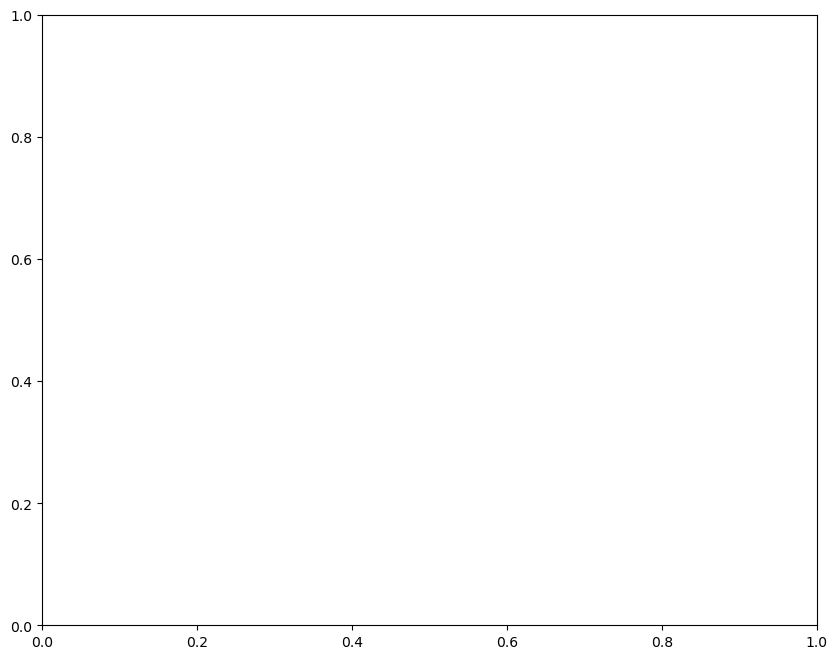

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energy"
ax_name = "ene"
min_ = 0.
max_ = 400.
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_pt_mgg"
full_hist.fill(ene = qcd_events[var1] * np.cosh(qcd_events.LeadPhoton_eta) * qcd_events.CMS_hgg_mass, weight=qcd_events.weight, c="new_lead")
full_hist.fill(ene = MC_events[var1][(MC_events.proc_id == -3)] * np.cosh(MC_events.LeadPhoton_eta[(MC_events.proc_id == -3)]) * MC_events.CMS_hgg_mass[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_pt_mgg"
full_hist.fill(ene = qcd_events[var2] * np.cosh(qcd_events.LeadPhoton_eta) * qcd_events.CMS_hgg_mass, weight=qcd_events.weight, c="new_sublead")
full_hist.fill(ene = MC_events[var2][(MC_events.proc_id == -3)] * np.cosh(MC_events.LeadPhoton_eta[(MC_events.proc_id == -3)]) * MC_events.CMS_hgg_mass[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

NameError: name 'qcd_events' is not defined

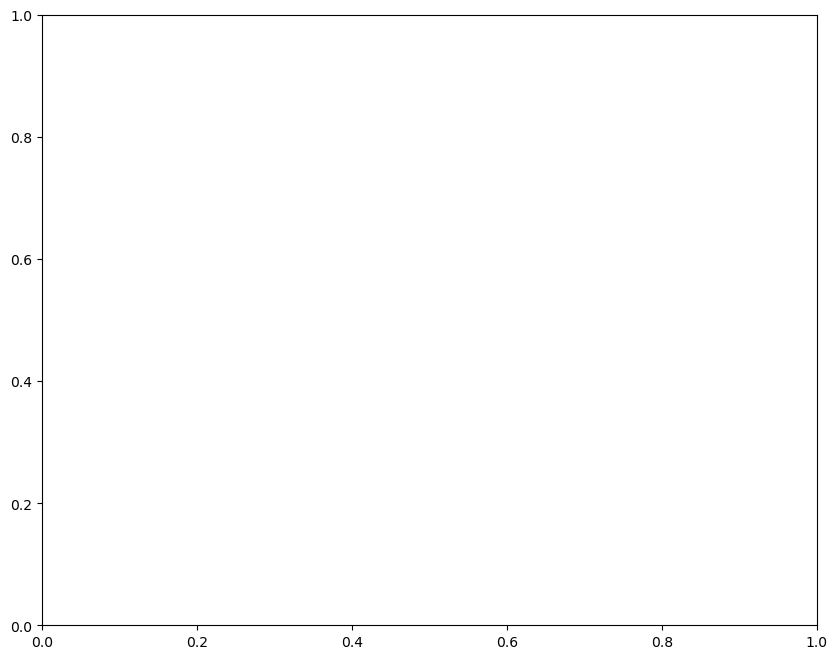

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMrv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["new", "old"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "sigmaMrv"
full_hist.fill(sigma = qcd_events[var1], weight=qcd_events.weight, c="new")
full_hist.fill(sigma = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False)
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")

NameError: name 'qcd_events' is not defined

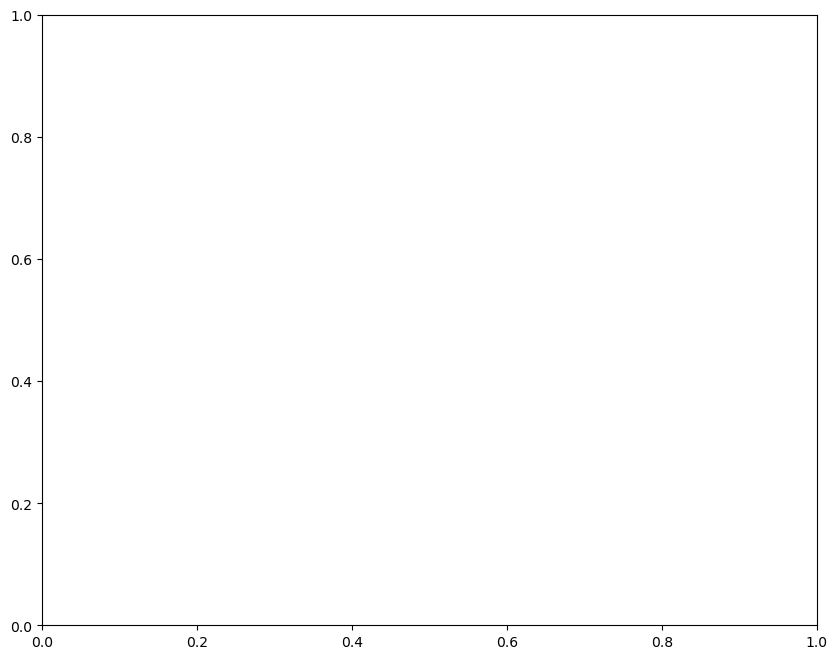

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="lead_pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_pt_mgg"
full_hist.fill(lead_pt_mgg = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(lead_pt_mgg = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_pt_mgg"
full_hist.fill(lead_pt_mgg = qcd_events[var2], weight=qcd_events.weight, c="new_sublead")
full_hist.fill(lead_pt_mgg = MC_events[var2][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

NameError: name 'qcd_events' is not defined

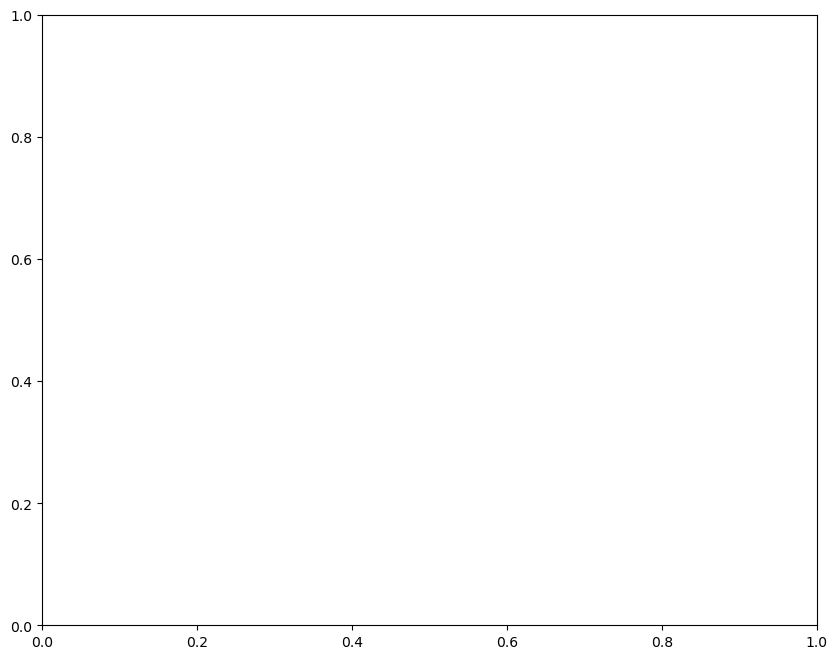

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 100
max_ = 180
nbins = 180

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["new", "old"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "CMS_hgg_mass"
full_hist.fill(mgg = qcd_events[var1], weight=qcd_events.weight, c="new")
full_hist.fill(mgg = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old")



h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

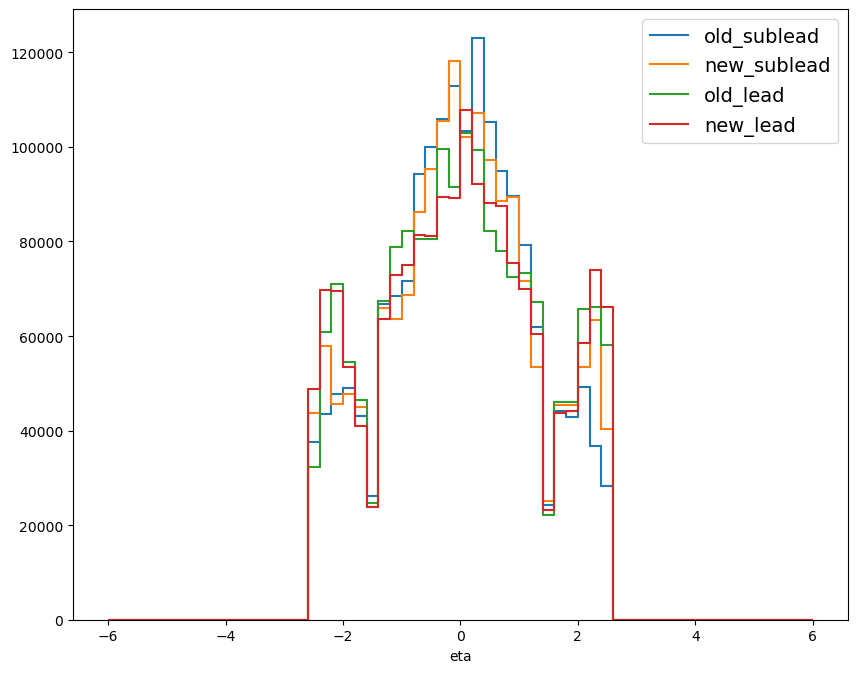

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -6
max_ = 6
nbins = 60

#for field in eta_fields:
#    MC_events[field] = MC_events[field] * np.sign(MC_events.eta)

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_eta"
full_hist.fill(eta = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(eta = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_eta"
full_hist.fill(eta = qcd_events[var2], weight=qcd_events.weight, c="new_sublead")
full_hist.fill(eta = MC_events[var2][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

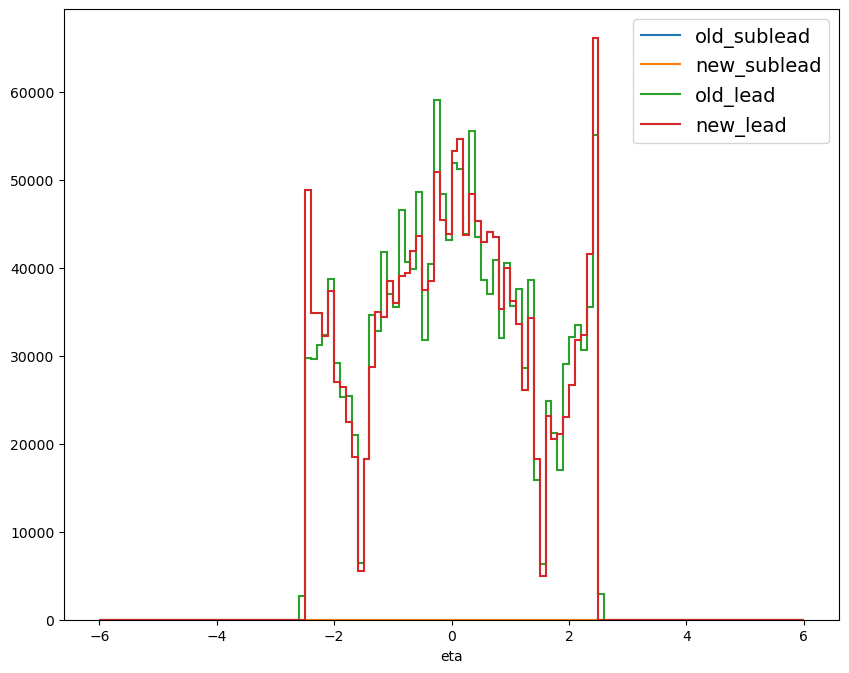

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_eta"
full_hist.fill(eta = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(eta = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")



h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

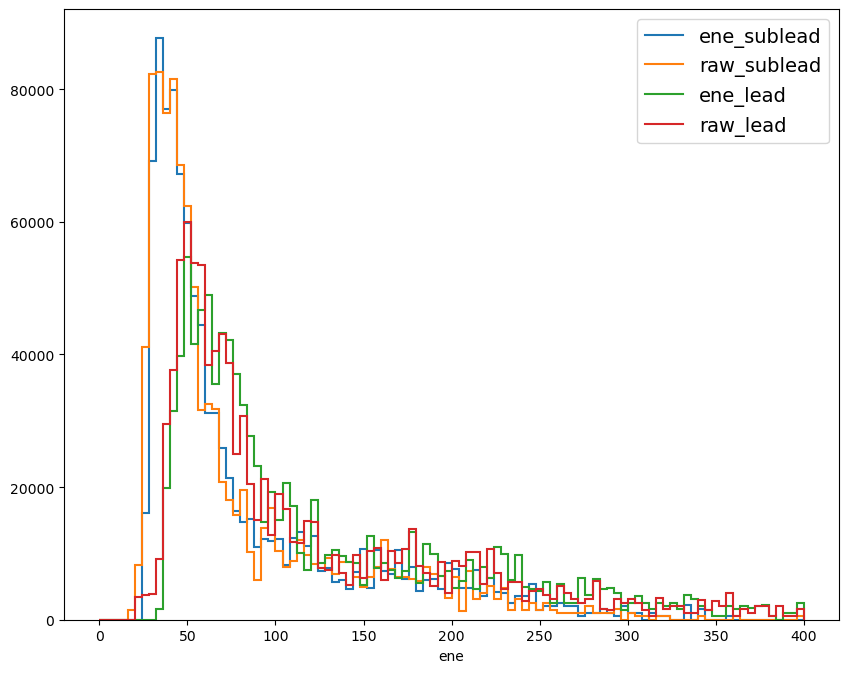

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energy"
ax_name = "ene"
min_ = 0.
max_ = 400.
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["raw_lead", "ene_lead", "raw_sublead", "ene_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_pt_mgg"
full_hist.fill(ene = MC_events["LeadPhoton_energyRaw"][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="raw_lead")
full_hist.fill(ene = MC_events["LeadPhoton_energy"][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="ene_lead")
var2 = "SubleadPhoton_pt_mgg"
full_hist.fill(ene = MC_events["SubleadPhoton_energyRaw"][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="raw_sublead")
full_hist.fill(ene = MC_events["SubleadPhoton_energy"][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="ene_sublead")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

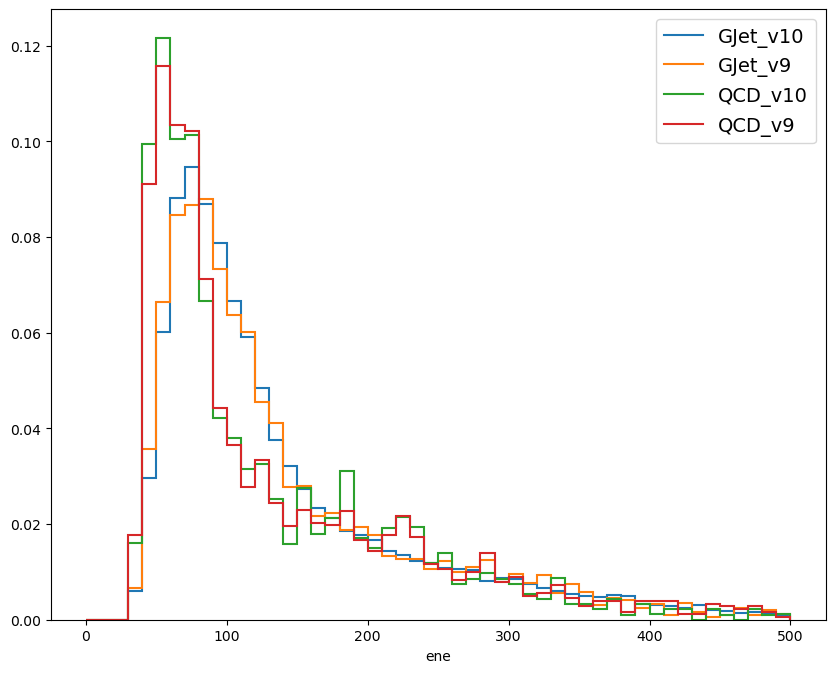

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energy"
ax_name = "ene"
min_ = 0.
max_ = 500.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["QCD_v9", "QCD_v10", "GJet_v9", "GJet_v10"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -98)], weight=bkg_events.weight[(bkg_events.proc_id == -98)] / sum (bkg_events.weight[(bkg_events.proc_id == -98)]), c="GJet_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -99)], weight=bkg_events.weight[(bkg_events.proc_id == -99)] / sum (bkg_events.weight[(bkg_events.proc_id == -99)]), c="GJet_v10")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -97)], weight=bkg_events.weight[(bkg_events.proc_id == -97)] / sum (bkg_events.weight[(bkg_events.proc_id == -97)]), c="QCD_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -96)], weight=bkg_events.weight[(bkg_events.proc_id == -96)] / sum (bkg_events.weight[(bkg_events.proc_id == -96)]), c="QCD_v10")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

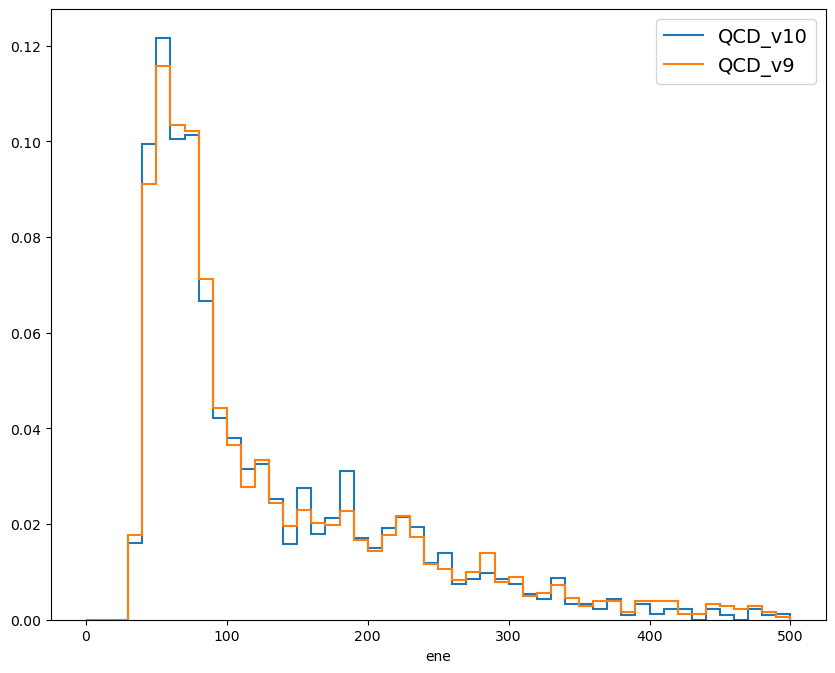

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energy"
ax_name = "ene"
min_ = 0.
max_ = 500.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["QCD_v9", "QCD_v10"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -97)], weight=bkg_events.weight[(bkg_events.proc_id == -97)] / sum (bkg_events.weight[(bkg_events.proc_id == -97)]), c="QCD_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -96)], weight=bkg_events.weight[(bkg_events.proc_id == -96)] / sum (bkg_events.weight[(bkg_events.proc_id == -96)]), c="QCD_v10")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

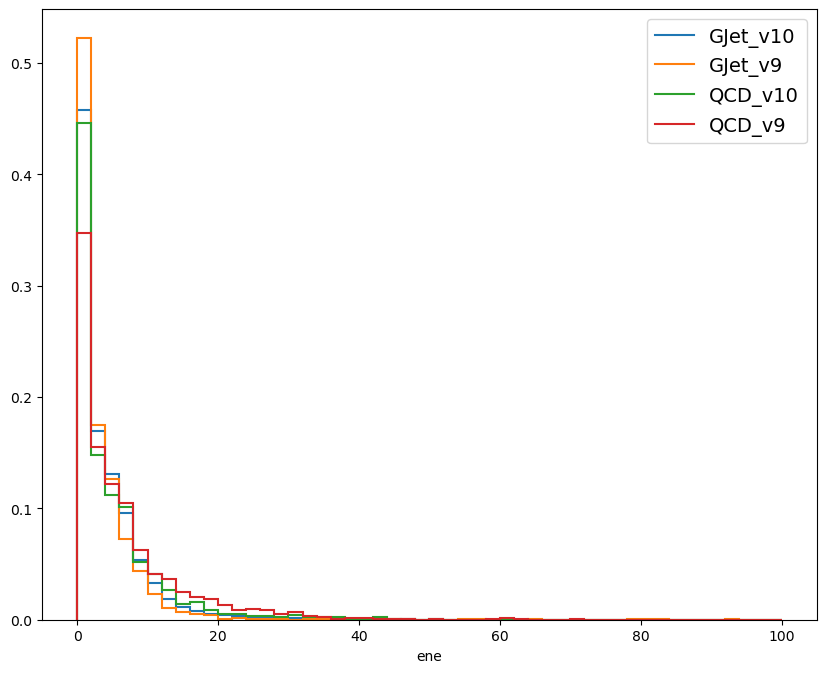

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energyErr"
ax_name = "ene"
min_ = 0.
max_ = 100.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["QCD_v9", "QCD_v10", "GJet_v9", "GJet_v10"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -98)], weight=bkg_events.weight[(bkg_events.proc_id == -98)] / sum (bkg_events.weight[(bkg_events.proc_id == -98)]), c="GJet_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -99)], weight=bkg_events.weight[(bkg_events.proc_id == -99)] / sum (bkg_events.weight[(bkg_events.proc_id == -99)]), c="GJet_v10")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -97)], weight=bkg_events.weight[(bkg_events.proc_id == -97)] / sum (bkg_events.weight[(bkg_events.proc_id == -97)]), c="QCD_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -96)], weight=bkg_events.weight[(bkg_events.proc_id == -96)] / sum (bkg_events.weight[(bkg_events.proc_id == -96)]), c="QCD_v10")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

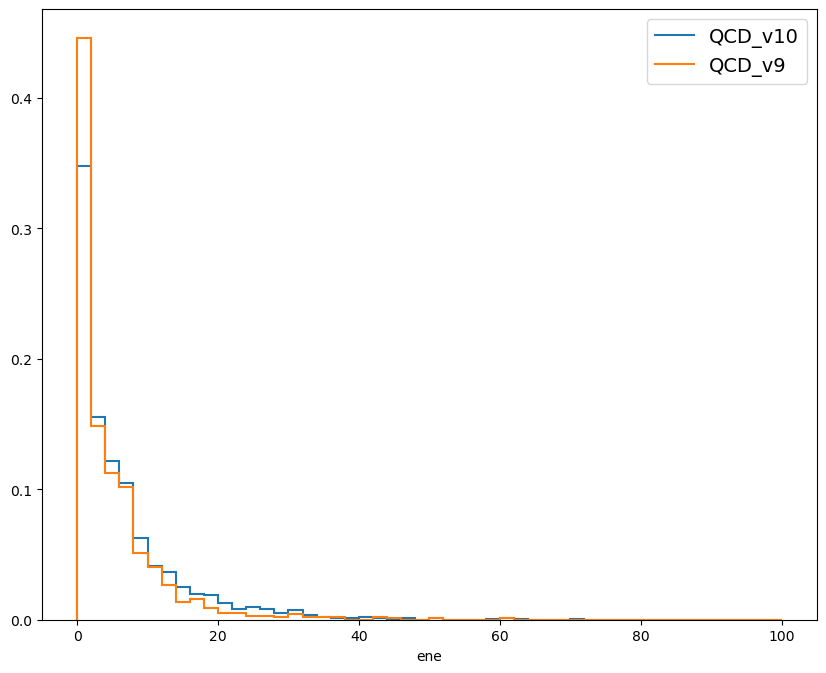

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energyErr"
ax_name = "ene"
min_ = 0.
max_ = 100.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["QCD_v9", "QCD_v10"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -97)], weight=bkg_events.weight[(bkg_events.proc_id == -97)] / sum (bkg_events.weight[(bkg_events.proc_id == -97)]), c="QCD_v10")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -96)], weight=bkg_events.weight[(bkg_events.proc_id == -96)] / sum (bkg_events.weight[(bkg_events.proc_id == -96)]), c="QCD_v9")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

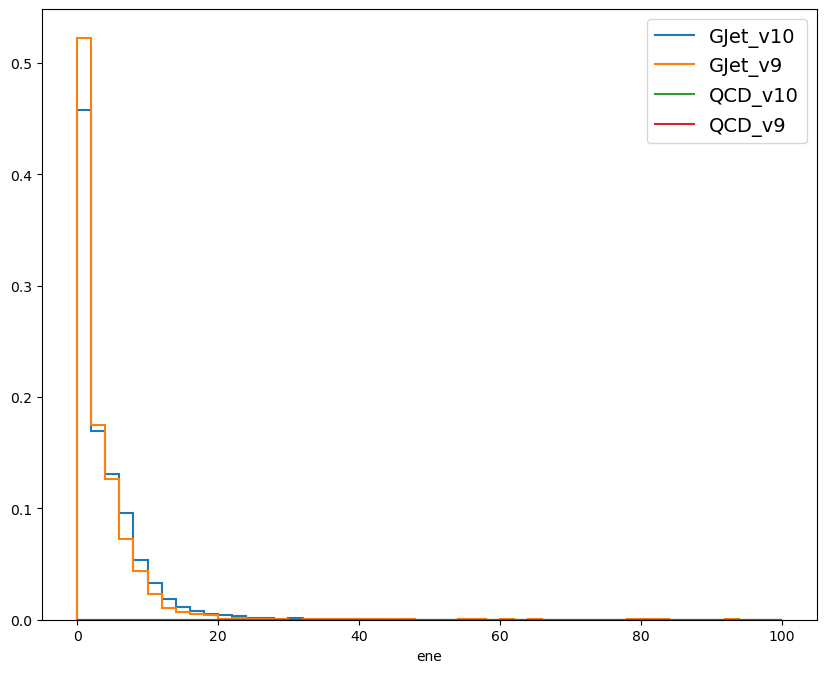

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energyErr"
ax_name = "ene"
min_ = 0.
max_ = 100.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["QCD_v9", "QCD_v10", "GJet_v9", "GJet_v10"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -98)], weight=bkg_events.weight[(bkg_events.proc_id == -98)] / sum (bkg_events.weight[(bkg_events.proc_id == -98)]), c="GJet_v9")
full_hist.fill(ene = bkg_events[var][(bkg_events.proc_id == -99)], weight=bkg_events.weight[(bkg_events.proc_id == -99)] / sum (bkg_events.weight[(bkg_events.proc_id == -99)]), c="GJet_v10")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})